# Multivariate Analysis

In [1]:
from utils.feature_importance import feature_importance, metrics, summary_plot,multivariate_importance
from utils.plotting_functions import dual_heat_map
import joblib
from sklearn.pipeline import Pipeline
import optuna
from utils.Reg_Models import RegModels
import pandas as pd
import seaborn as sns
import numpy as np
from numpy import load
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings # Ignore alert messages
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedShuffleSplit, TimeSeriesSplit, RepeatedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LassoLarsCV, LassoCV, Lasso

import xgboost as xgb
import eli5
from eli5.sklearn import PermutationImportance

from yellowbrick.model_selection import FeatureImportances
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from yellowbrick.model_selection import learning_curve
from yellowbrick.model_selection import feature_importances
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv(r'C:\Users\DELL\Desktop\PG\nadal_fra6.csv',sep=';')

In [3]:
def create_scaled_dataset(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state=0,shuffle=False) 

    std_scaler = StandardScaler()
    X_scaled_train = pd.DataFrame(std_scaler.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
    X_scaled_test = pd.DataFrame(std_scaler.transform(X_test),columns=X_train.columns,index=X_test.index)
    return X_scaled_train,X_scaled_test, y_train,y_test

In [4]:
X, y = df[['CC_FL','CC_BL','AT_Y','CC_BR','CC_FR',
'AU_395_L','AU_355_L','AT_X','AT_Z']], df[['L/V_BR']]
X_train_scaled,X_test_scaled,y_train,y_test = create_scaled_dataset(X,y)

## Distribuição dados Treino x Teste para essa distribuição

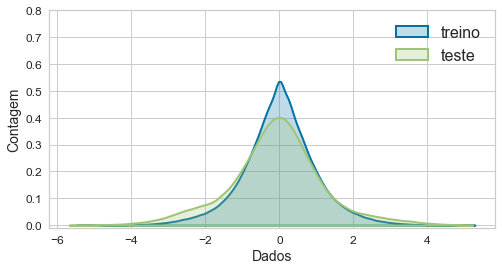

In [25]:
plt.figure(figsize=(8,4))
sns.distplot(X_train_scaled, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'treino')
sns.distplot(X_test_scaled, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'teste')
plt.xlabel("Dados", size=14)
plt.ylabel("Contagem", size=14)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
#plt.title("Dados treino x teste (X)")
plt.ylim([-0.01,0.8])

plt.legend(loc='upper right',fontsize=16)

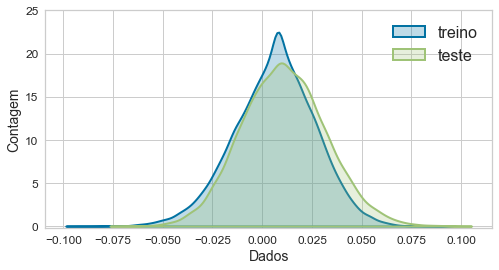

In [26]:
plt.figure(figsize=(8,4))
sns.distplot(y_train, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'treino')
sns.distplot(y_test, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 2},
                  label = 'teste')
plt.xlabel("Dados", size=14)
plt.ylabel("Contagem", size=14)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.ylim([-0.2,25])
plt.legend(loc='upper right',fontsize=16)

A distribuição parece ser representativa, podemos seguir em frente

In [5]:
from yellowbrick.model_selection import FeatureImportances
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import numpy as np
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from yellowbrick.model_selection import learning_curve
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from yellowbrick.model_selection import feature_importances
import xgboost as xgb
from sklearn.linear_model import ElasticNet
import eli5
from tqdm import tqdm
from eli5.sklearn import PermutationImportance



def summary_plot(model,X_train,y_train,X_test,y_test,cv,train_sizes=np.linspace(0.1,1.0,5),lc=False):

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
    plt.rc('legend',fontsize=12.5) 


    visualize_residuals = residuals_plot(model,X_train, y_train, X_test, y_test,show=False,ax=ax[0],title=' ');
    ax[0].tick_params(labelsize=13)
    ax[0].set_xlabel('Predicted value (mm)',fontsize=16)
    ax[0].set_ylabel('Residuals (mm)',fontsize=16)

    visualizer = prediction_error(model, X_test, y_test, show=False, ax=ax[1], title=' ')
    ax[1].tick_params(labelsize=13)
    ax[1].set_xlabel('Predicted value (mm)',fontsize=16)
    ax[1].set_ylabel('Real value (mm)',fontsize=16)

    if lc:
        print('Plotting learning curves')
        visual_LC = learning_curve(model, X_train, y_train,scoring='r2',cv=cv,ax=ax[2],title=' ',show=False,train_sizes=train_sizes,n_jobs=-1);
        ax[2].set_ylim([0.6, 1.05])
        ax[2].tick_params(labelsize=13)
        ax[2].set_xlabel('Number of training instances',fontsize=16)
        ax[2].set_ylabel(r'$R^2$' + ' metric',fontsize=16)
        
    plt.show()
    
    return


def metrics(y_test,predict):
    
    mse = mean_squared_error(y_test,predict)
    mae= mean_absolute_error(y_test,predict)
    r2= r2_score(y_test,predict)
    return print("MSE:{}".format(mse),"\nMAE:{}".format(mae),"\nR2:{}".format(r2))


def feature_importance(X_train,y_train,X_test,y_test,relative=True,topn=9):
    
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10),sharex=True)
    plt.rc('legend',fontsize=12.5) 

    ################################################################
    # Lasso Regression
    ################################################################
    
    mod = Lasso(alpha=0.001)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    viz1 = FeatureImportances(Lasso(alpha=0.001),relative=relative,topn=topn, title =' ',ax=ax[0,0],absolute=True)
    viz1.fit(X_train,y_train)
    ax[0,0].tick_params(labelsize=13)
    ax[0,0].set_title('Lasso Regression - R^2 = {}'.format(r2),fontsize=20)

    ################################################################

    mod = RandomForestRegressor(**study_rf.best_params,random_state=2020)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    rfr = RandomForestRegressor(**study_rf.best_params,random_state=2020)
    viz2 = FeatureImportances(rfr,relative=relative, topn=topn, title =' ',ax=ax[0,1])
    viz2.fit(X_train,y_train)
    ax[0,1].tick_params(labelsize=13)
    ax[0,1].set_title('RandomForestRegressor - R^2 = {}'.format(r2),fontsize=20)
    
    ################################################################

    mod = xgb.XGBRegressor(**study_xgb.best_params,random_state=2020)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    abr = xgb.XGBRegressor(**study_xgb.best_params,random_state=2020)
    viz3 = FeatureImportances(abr,relative=relative, topn=topn, title =' ', ax=ax[1,0])
    viz3.fit(X_train,y_train)
    ax[1,0].tick_params(labelsize=13)
    ax[1,0].set_xlabel('Relative feature importance',fontsize=16)
    ax[1,0].set_title('XGBoostRegressor - R^2 = {}'.format(r2),fontsize=20)
  
    ################################################################
    
    mod = ElasticNet(**study_en.best_params,random_state=2020)
    mod.fit(X_train,y_train)
    r2 = r2_score(y_test,mod.predict(X_test))
    
    gbr = ElasticNet(**study_en.best_params,random_state=2020)
    viz4 = FeatureImportances(gbr,relative=relative, topn=topn, title =' ',ax=ax[1,1])
    viz4.fit(X_train,y_train)
    ax[1,1].tick_params(labelsize=13)
    ax[1,1].set_xlabel('Relative feature importance',fontsize=16)
    ax[1,1].set_title('ElasticNet - R^2 = {}'.format(r2),fontsize=20)

    plt.tight_layout()
    plt.show()
    
    return


class multivariate_importance():
    def __init__(self, X_train, X_test, y_train, y_test, nmodels=6):

        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.nmodels = nmodels

        mod1 = Lasso(alpha=0.001)
        mod2 = RandomForestRegressor(**study_rf.best_params,random_state=2020)
        mod3 = xgb.XGBRegressor(**study_xgb.best_params,random_state=2020)
        mod4 = GradientBoostingRegressor(**study_rf.best_params,random_state=2020)
        mod5 = ExtraTreesRegressor(**study_et.best_params,random_state=2020, n_jobs=-1)
        mod6 = ElasticNet(**study_en.best_params,random_state=2020)

        self.mod_list = [mod1, mod2,
                         mod3, mod4,
                         mod5, mod6]

        self.mod_list = self.mod_list[0:self.nmodels]

        self.model_r2 = None

        print('All models for determining feature importance')
        print(self.mod_list)
        print('')

    def train_models(self):

        model_r2 = []
        for model in tqdm(self.mod_list):
            model.fit(self.X_train, self.y_train)
            model_r2.append(np.round(r2_score(self.y_test, model.predict(self.X_test)), 4))

        self.model_r2 = model_r2

        return model_r2

    def permutation_importance(self, model_index=1):

        self.mod_list[model_index].fit(self.X_train, self.y_train)
        perm = PermutationImportance(self.mod_list[model_index], random_state=1).fit(
            self.X_train, self.y_train)
        return eli5.show_weights(perm, feature_names=X_train.columns.tolist())

    def plot(self, relative=True, topn=9, absolute=True, plot_R2=True):

        fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 18))

        if self.model_r2 == None:
            print('Obtaining R2 score for all 6 models')
            multivariate_importance.train_models(self)
            print('R2 score calculated')

        print('Obtaining feature importance - 0%')
        viz1 = FeatureImportances(self.mod_list[0], relative=relative, topn=topn, ax=ax[0, 0], absolute=absolute)
        viz1.fit(self.X_train, self.y_train)
        ax[0, 0].tick_params(labelsize=16)

        viz2 = FeatureImportances(self.mod_list[1], relative=relative, topn=topn, ax=ax[0, 1], absolute=absolute)
        viz2.fit(self.X_train, self.y_train)
        ax[0, 1].tick_params(labelsize=16)

        viz3 = FeatureImportances(self.mod_list[2], relative=relative, topn=topn, ax=ax[0, 2], absolute=absolute)
        viz3.fit(self.X_train, self.y_train)
        ax[0, 2].tick_params(labelsize=18)
        print('Obtaining feature importance - 50%')
        viz4 = FeatureImportances(self.mod_list[3], relative=relative, topn=topn, ax=ax[1, 0], absolute=absolute)
        viz4.fit(self.X_train, self.y_train)
        ax[1, 0].tick_params(labelsize=18)

        viz5 = FeatureImportances(self.mod_list[4], relative=relative, topn=topn, ax=ax[1, 1], absolute=absolute)
        viz5.fit(self.X_train, self.y_train)
        ax[1, 1].tick_params(labelsize=18)

        viz6 = FeatureImportances(self.mod_list[5], relative=relative, topn=topn, ax=ax[1, 2], absolute=absolute)
        viz6.fit(self.X_train, self.y_train)
        ax[1, 2].tick_params(labelsize=18)
        print('Obtaining feature importance - 100%')

        if plot_R2:

            ax[0, 0].set_title(
                'Lasso Regression - $R^2$ = {}'.format(self.model_r2[0]), fontsize=25)
            ax[0, 1].set_title(
                'RandomForestRegressor - $R^2$ = {}'.format(self.model_r2[1]), fontsize=25)
            ax[0, 2].set_title(
                'XGBoostRegressor - $R^2$ = {}'.format(self.model_r2[2]), fontsize=25)
            ax[1, 0].set_title(
                'GradientBoostingRegressor - $R^2$ = {}'.format(self.model_r2[3]), fontsize=25)
            ax[1, 1].set_title(
                'ExtraTreesRegressor - $R^2$ = {}'.format(self.model_r2[4]), fontsize=25)
            ax[1, 2].set_title(
                'ElasticNet - $R^2$ = {}'.format(self.model_r2[5]), fontsize=25)

            ax[0, 0].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 1].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 2].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 0].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 1].set_xlabel('Coefficient value', fontsize=24)
            ax[1, 2].set_xlabel('Coefficient value', fontsize=24)
            ax[0, 0].set_xlim([0,0.1])
            #ax[0, 1].set_xlim([0,0.5])
            #ax[0, 2].set_xlim([0,0.5])
            #ax[1, 0].set_xlim([0,0.5])
            #ax[1, 1].set_xlim([0,0.5])
            ax[1, 2].set_xlim([0,0.1])

        plt.tight_layout()
        return


In [6]:
study_rf = joblib.load("study_RandomForest_FR_FRA6.pkl")
study_ab = joblib.load("study_AdaBost.pkl")
study_en = joblib.load("study_ElasticNet_FR_FRA6.pkl")
study_xgb = joblib.load("study_XGBoost.pkl")
study_et = joblib.load("study_Extratrees.pkl")


In [9]:
jalkkhkjhsfkhlajjç

NameError: name 'jalkkhkjhsfkhlajjç' is not defined

All models for determining feature importance
[Lasso(alpha=0.001), RandomForestRegressor(max_depth=12, max_features=7, min_samples_leaf=2,
                      min_samples_split=4, n_estimators=525, random_state=2020), XGBRegressor(alpha=0.02111400159780091, base_score=None, booster=None,
             colsample_bylevel=0.9000000000000001, colsample_bynode=1.0,
             colsample_bytree=0.6000000000000001, enable_categorical=False,
             gamma=None, gpu_id=None, importance_type=None,
             interaction_constraints=None, lambda=0.001530808845481313,
             learning_rate=None, max_delta_step=None, max_depth=10,
             min_child_weight=7.1, min_split_loss=0.0027632330369892592,
             missing=nan, monotone_constraints=None, n_estimators=5850,
             n_jobs=None, num_parallel_tree=None, predictor=None,
             random_state=2020, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=0.7000000000000001,
             tree_

  0%|          | 0/6 [00:00<?, ?it/s]C:\Users\DELL\AppData\Local\Temp\ipykernel_11924\1172260965.py:150: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(self.X_train, self.y_train)
 33%|███▎      | 2/6 [02:11<04:22, 65.75s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
 50%|█████     | 3/6 [08:08<09:20, 186.99s/it]c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 67%|██████▋   | 4/6 [12:09<06:54, 2

R2 score calculated
Obtaining feature importance - 0%
Obtaining feature importance - 50%


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ExtraTreesRegressor was fitted with feature names
  warnings.warn(
c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(


Obtaining feature importance - 100%
CPU times: total: 26min
Wall time: 12min 22s


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

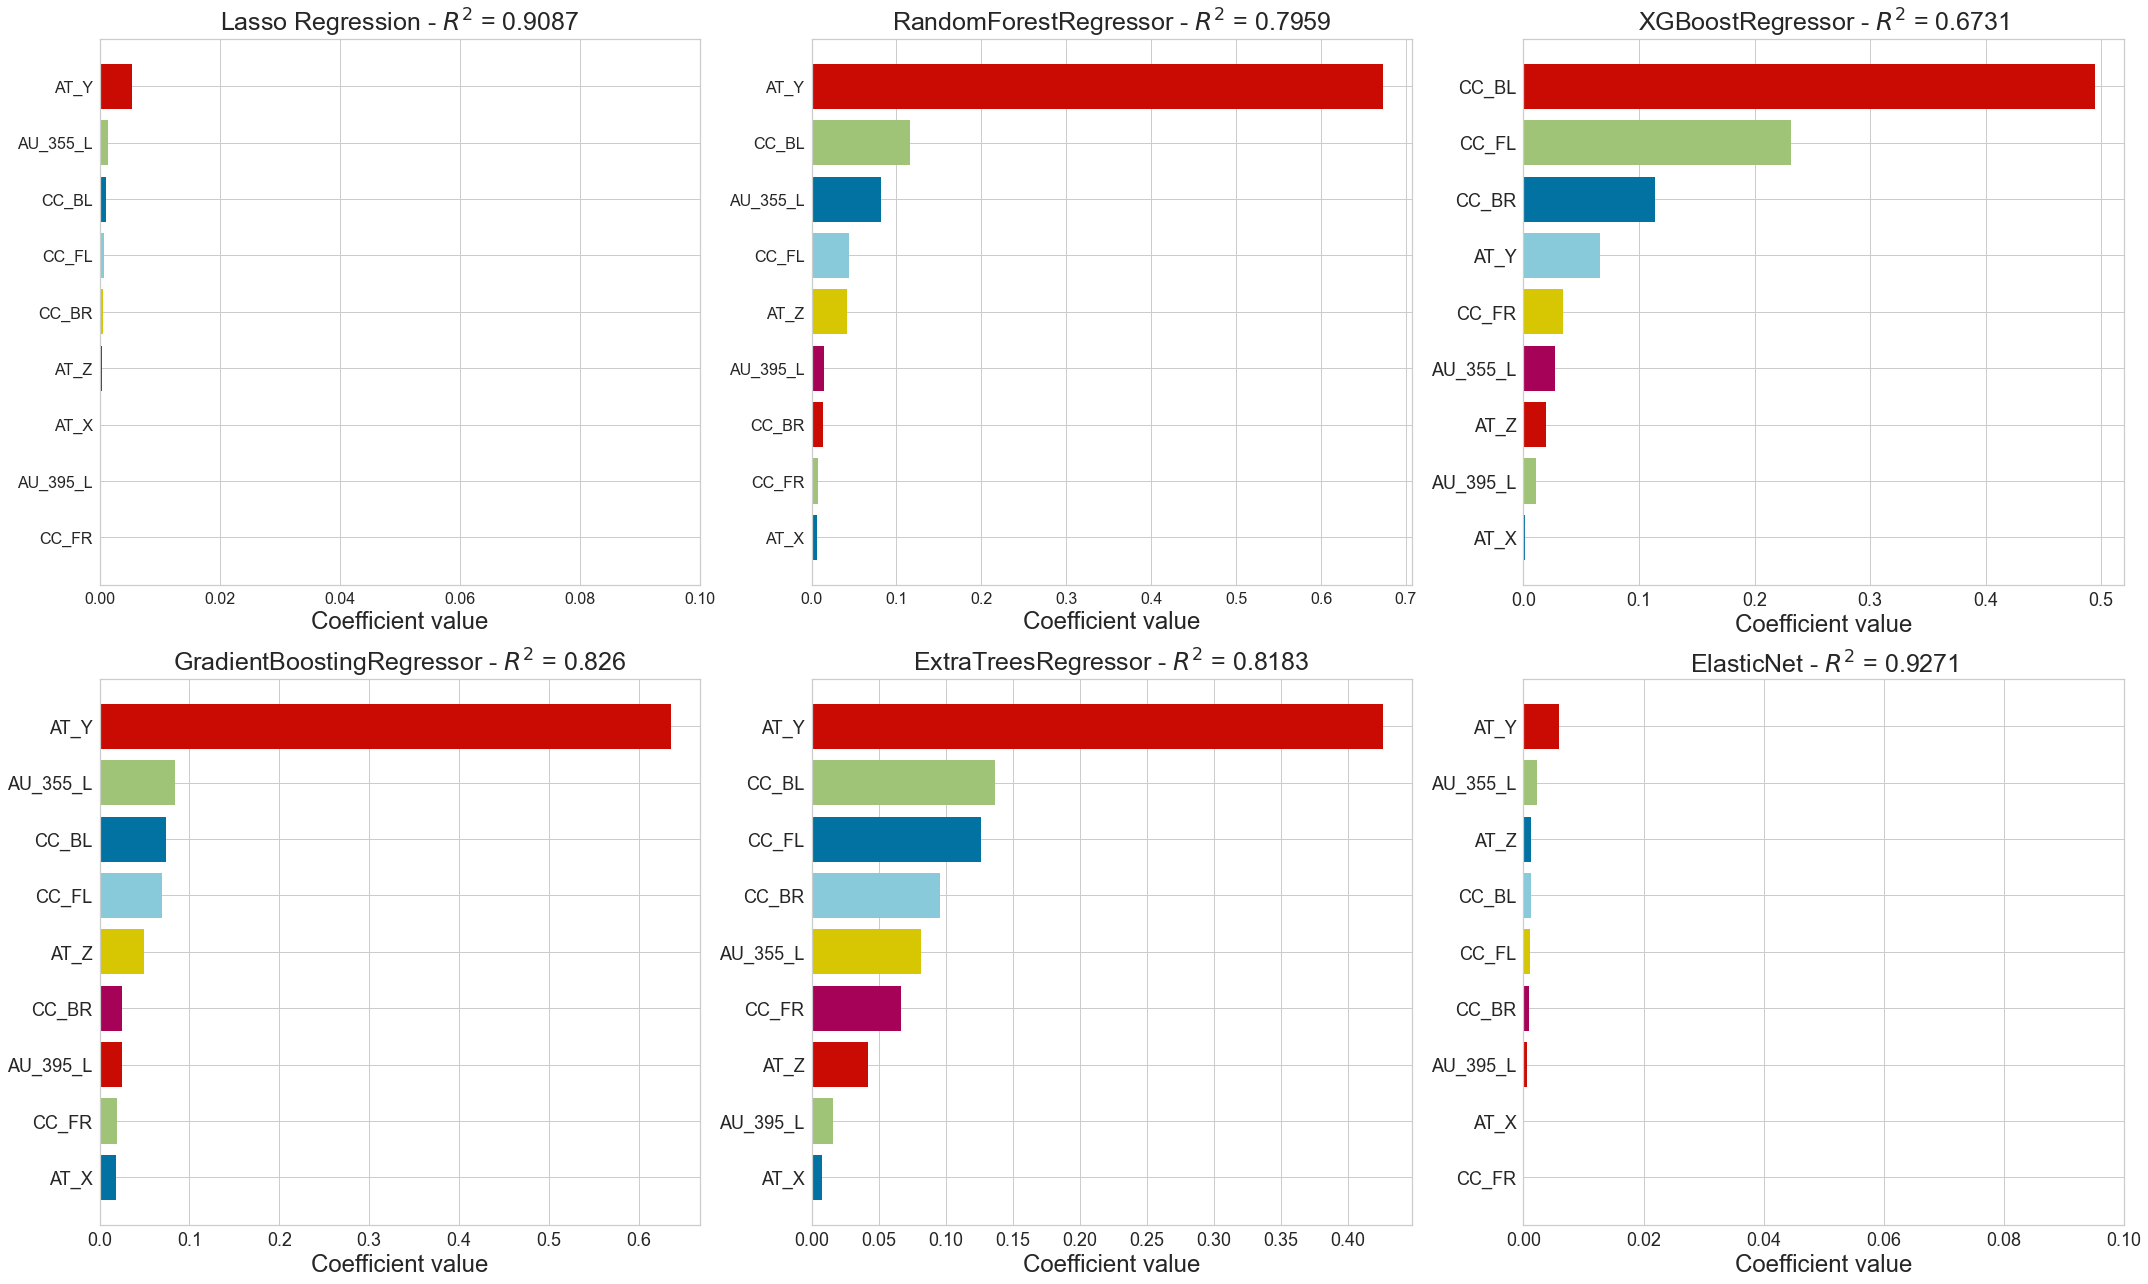

In [7]:
%%time
multi_select = multivariate_importance(X_train_scaled,X_test_scaled,y_train,y_test)     
multi_select.plot(relative=False)
import warnings # Ignore alert messages
warnings.simplefilter(action='ignore', category=FutureWarning)

np.seterr(divide='ignore')

# Optuna study

In [ ]:
#X, y = df_nadal[['CC_FR', 'CC_FL', 'CC_BR', 'CC_BL','AT_Y',
#'AU_395_FR','AU_395_FL','AU_275_FR','AU_275_FL']], df_nadal[['L/V_FR']]
#X_train_scaled,X_test_scaled,y_train,y_test = create_scaled_dataset(X,y)

### Random Forest - FR

In [12]:
import optuna

def objective(trial):
    
    joblib.dump(study, 'study.pkl')
    
    f_n_estimators = trial.suggest_int("n_estimators", low=200,high=1000,step=25)
    f_max_depth = trial.suggest_int("max_depth", low=2,high=50,step=2)
    f_min_samples_leaf = trial.suggest_int("min_samples_leaf", low=1, high=20, step=1)
    f_min_samples_split = trial.suggest_int("min_samples_split", low=2, high=20, step=1)
    int_max_features = np.arange(2,len(X_train_scaled.columns),1,dtype=int) 
    max_features_list = []
    for e in int_max_features: 
       max_features_list.append(int(e))
    f_max_features = trial.suggest_categorical("max_features",max_features_list) 
     
    model = RandomForestRegressor(max_depth=f_max_depth,
                                           n_estimators = f_n_estimators,
                                           min_samples_split = f_min_samples_split,
                                           min_samples_leaf = f_min_samples_leaf,
                                           max_features = f_max_features,
                                           random_state=0, 
                                           n_jobs = -1)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study = optuna.create_study(direction='maximize')

[I 2022-12-09 12:17:54,919] A new study created in memory with name: no-name-8727386c-7a28-402d-9b9a-30ba829a64f3


In [13]:
study.optimize(objective, n_trials=50,show_progress_bar=True)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:18:35,744] Trial 0 finished with value: 0.8019374821142056 and parameters: {'n_estimators': 300, 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 8, 'max_features': 5}. Best is trial 0 with value: 0.8019374821142056.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:19:28,666] Trial 1 finished with value: 0.8021745215316305 and parameters: {'n_estimators': 675, 'max_depth': 34, 'min_samples_leaf': 9, 'min_samples_split': 18, 'max_features': 5}. Best is trial 1 with value: 0.8021745215316305.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:19:57,455] Trial 2 finished with value: 0.8058649651262927 and parameters: {'n_estimators': 250, 'max_depth': 16, 'min_samples_leaf': 14, 'min_samples_split': 7, 'max_features': 8}. Best is trial 2 with value: 0.8058649651262927.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:20:35,534] Trial 3 finished with value: 0.8037900465116409 and parameters: {'n_estimators': 375, 'max_depth': 28, 'min_samples_leaf': 5, 'min_samples_split': 15, 'max_features': 6}. Best is trial 2 with value: 0.8058649651262927.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:21:38,325] Trial 4 finished with value: 0.8012369179861379 and parameters: {'n_estimators': 800, 'max_depth': 8, 'min_samples_leaf': 19, 'min_samples_split': 16, 'max_features': 8}. Best is trial 2 with value: 0.8058649651262927.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:22:22,744] Trial 5 finished with value: 0.7773689507233282 and parameters: {'n_estimators': 950, 'max_depth': 20, 'min_samples_leaf': 19, 'min_samples_split': 11, 'max_features': 3}. Best is trial 2 with value: 0.8058649651262927.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:23:51,520] Trial 6 finished with value: 0.8025973268491088 and parameters: {'n_estimators': 975, 'max_depth': 20, 'min_samples_leaf': 12, 'min_samples_split': 10, 'max_features': 6}. Best is trial 2 with value: 0.8058649651262927.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:24:24,270] Trial 7 finished with value: 0.8074776603090736 and parameters: {'n_estimators': 250, 'max_depth': 24, 'min_samples_leaf': 2, 'min_samples_split': 3, 'max_features': 7}. Best is trial 7 with value: 0.8074776603090736.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:24:57,561] Trial 8 finished with value: 0.8057202151285705 and parameters: {'n_estimators': 300, 'max_depth': 14, 'min_samples_leaf': 12, 'min_samples_split': 15, 'max_features': 8}. Best is trial 7 with value: 0.8074776603090736.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:25:45,477] Trial 9 finished with value: 0.8002290007036692 and parameters: {'n_estimators': 625, 'max_depth': 28, 'min_samples_leaf': 13, 'min_samples_split': 17, 'max_features': 5}. Best is trial 7 with value: 0.8074776603090736.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:27:00,521] Trial 10 finished with value: 0.8052740549527139 and parameters: {'n_estimators': 475, 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 3, 'max_features': 7}. Best is trial 7 with value: 0.8074776603090736.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:27:09,768] Trial 11 finished with value: 0.6227449122057206 and parameters: {'n_estimators': 225, 'max_depth': 4, 'min_samples_leaf': 15, 'min_samples_split': 3, 'max_features': 7}. Best is trial 7 with value: 0.8074776603090736.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:27:28,140] Trial 12 finished with value: 0.7620327520848026 and parameters: {'n_estimators': 450, 'max_depth': 38, 'min_samples_leaf': 8, 'min_samples_split': 6, 'max_features': 2}. Best is trial 7 with value: 0.8074776603090736.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:27:39,917] Trial 13 finished with value: 0.7892115583397517 and parameters: {'n_estimators': 200, 'max_depth': 12, 'min_samples_leaf': 16, 'min_samples_split': 6, 'max_features': 4}. Best is trial 7 with value: 0.8074776603090736.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:29:07,786] Trial 14 finished with value: 0.8075331691248306 and parameters: {'n_estimators': 500, 'max_depth': 42, 'min_samples_leaf': 1, 'min_samples_split': 2, 'max_features': 8}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:30:27,448] Trial 15 finished with value: 0.8056878725532631 and parameters: {'n_estimators': 500, 'max_depth': 48, 'min_samples_leaf': 1, 'min_samples_split': 2, 'max_features': 7}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:31:13,940] Trial 16 finished with value: 0.7913350436171012 and parameters: {'n_estimators': 750, 'max_depth': 40, 'min_samples_leaf': 5, 'min_samples_split': 4, 'max_features': 3}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:31:37,139] Trial 17 finished with value: 0.768486622774591 and parameters: {'n_estimators': 550, 'max_depth': 34, 'min_samples_leaf': 3, 'min_samples_split': 20, 'max_features': 2}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:32:05,160] Trial 18 finished with value: 0.7977848589590035 and parameters: {'n_estimators': 400, 'max_depth': 44, 'min_samples_leaf': 7, 'min_samples_split': 12, 'max_features': 4}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:33:01,077] Trial 19 finished with value: 0.8060697068512659 and parameters: {'n_estimators': 325, 'max_depth': 32, 'min_samples_leaf': 3, 'min_samples_split': 5, 'max_features': 8}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:34:59,593] Trial 20 finished with value: 0.8067453985807459 and parameters: {'n_estimators': 850, 'max_depth': 24, 'min_samples_leaf': 3, 'min_samples_split': 9, 'max_features': 7}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:37:05,867] Trial 21 finished with value: 0.8066381893717501 and parameters: {'n_estimators': 850, 'max_depth': 24, 'min_samples_leaf': 3, 'min_samples_split': 2, 'max_features': 7}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:38:47,865] Trial 22 finished with value: 0.8061888136876254 and parameters: {'n_estimators': 700, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 8, 'max_features': 7}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:40:02,964] Trial 23 finished with value: 0.8065283598204309 and parameters: {'n_estimators': 600, 'max_depth': 22, 'min_samples_leaf': 3, 'min_samples_split': 4, 'max_features': 7}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:41:48,739] Trial 24 finished with value: 0.8060744912052696 and parameters: {'n_estimators': 875, 'max_depth': 38, 'min_samples_leaf': 6, 'min_samples_split': 13, 'max_features': 7}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:42:58,225] Trial 25 finished with value: 0.8063224078800748 and parameters: {'n_estimators': 550, 'max_depth': 26, 'min_samples_leaf': 10, 'min_samples_split': 9, 'max_features': 8}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:43:54,319] Trial 26 finished with value: 0.8050568530550313 and parameters: {'n_estimators': 425, 'max_depth': 44, 'min_samples_leaf': 2, 'min_samples_split': 5, 'max_features': 7}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:44:59,315] Trial 27 finished with value: 0.7992879388839863 and parameters: {'n_estimators': 900, 'max_depth': 16, 'min_samples_leaf': 4, 'min_samples_split': 2, 'max_features': 4}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:45:32,187] Trial 28 finished with value: 0.7613160137695267 and parameters: {'n_estimators': 750, 'max_depth': 24, 'min_samples_leaf': 6, 'min_samples_split': 7, 'max_features': 2}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:45:58,373] Trial 29 finished with value: 0.7935568077611715 and parameters: {'n_estimators': 350, 'max_depth': 34, 'min_samples_leaf': 4, 'min_samples_split': 8, 'max_features': 3}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:46:36,296] Trial 30 finished with value: 0.8036644593424266 and parameters: {'n_estimators': 275, 'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 4, 'max_features': 6}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:48:50,054] Trial 31 finished with value: 0.8067932809927512 and parameters: {'n_estimators': 875, 'max_depth': 24, 'min_samples_leaf': 2, 'min_samples_split': 2, 'max_features': 7}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:50:48,703] Trial 32 finished with value: 0.8060701175554359 and parameters: {'n_estimators': 800, 'max_depth': 24, 'min_samples_leaf': 1, 'min_samples_split': 3, 'max_features': 7}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:52:26,747] Trial 33 finished with value: 0.8019310498810466 and parameters: {'n_estimators': 1000, 'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'max_features': 5}. Best is trial 14 with value: 0.8075331691248306.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:53:35,571] Trial 34 finished with value: 0.8088443068300946 and parameters: {'n_estimators': 675, 'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 5, 'max_features': 7}. Best is trial 34 with value: 0.8088443068300946.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:54:23,118] Trial 35 finished with value: 0.7761585919803281 and parameters: {'n_estimators': 675, 'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 5, 'max_features': 8}. Best is trial 34 with value: 0.8088443068300946.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:55:22,819] Trial 36 finished with value: 0.8099171028675878 and parameters: {'n_estimators': 525, 'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 4, 'max_features': 7}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:56:22,452] Trial 37 finished with value: 0.807720623398656 and parameters: {'n_estimators': 575, 'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 6, 'max_features': 8}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:57:15,643] Trial 38 finished with value: 0.8045149378416766 and parameters: {'n_estimators': 550, 'max_depth': 8, 'min_samples_leaf': 9, 'min_samples_split': 6, 'max_features': 8}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:57:33,734] Trial 39 finished with value: 0.43491515096113353 and parameters: {'n_estimators': 625, 'max_depth': 2, 'min_samples_leaf': 8, 'min_samples_split': 7, 'max_features': 8}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:58:30,399] Trial 40 finished with value: 0.8059090311304014 and parameters: {'n_estimators': 500, 'max_depth': 12, 'min_samples_leaf': 17, 'min_samples_split': 4, 'max_features': 8}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 12:59:17,438] Trial 41 finished with value: 0.80390471125803 and parameters: {'n_estimators': 600, 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 3, 'max_features': 6}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 13:00:22,608] Trial 42 finished with value: 0.8036795327183375 and parameters: {'n_estimators': 650, 'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 5, 'max_features': 5}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 13:01:23,475] Trial 43 finished with value: 0.8066804849229772 and parameters: {'n_estimators': 725, 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 3, 'max_features': 8}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 13:02:15,575] Trial 44 finished with value: 0.8074987020525253 and parameters: {'n_estimators': 525, 'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 6, 'max_features': 7}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 13:03:19,154] Trial 45 finished with value: 0.8080657003556342 and parameters: {'n_estimators': 525, 'max_depth': 14, 'min_samples_leaf': 4, 'min_samples_split': 7, 'max_features': 8}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 13:04:17,534] Trial 46 finished with value: 0.8055836725632473 and parameters: {'n_estimators': 450, 'max_depth': 18, 'min_samples_leaf': 12, 'min_samples_split': 8, 'max_features': 8}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 13:05:30,365] Trial 47 finished with value: 0.8074135848107116 and parameters: {'n_estimators': 575, 'max_depth': 14, 'min_samples_leaf': 7, 'min_samples_split': 7, 'max_features': 8}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 13:06:02,667] Trial 48 finished with value: 0.7752492891169203 and parameters: {'n_estimators': 475, 'max_depth': 6, 'min_samples_leaf': 11, 'min_samples_split': 11, 'max_features': 8}. Best is trial 36 with value: 0.8099171028675878.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\55366690.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_scaled,y_train)


[I 2022-12-09 13:06:10,861] Trial 49 finished with value: 0.2354682880688329 and parameters: {'n_estimators': 650, 'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 4, 'max_features': 3}. Best is trial 36 with value: 0.8099171028675878.
Accuracy: 0.8099171028675878
Best hyperparameters: {'n_estimators': 525, 'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 4, 'max_features': 7}


In [14]:
joblib.dump(study, "study_RandomForest_FR_FRA6.pkl")

['study_RandomForest_FR_FRA6.pkl']

In [15]:
study.best_trial

FrozenTrial(number=36, values=[0.8099171028675878], datetime_start=datetime.datetime(2022, 12, 9, 12, 54, 23, 127016), datetime_complete=datetime.datetime(2022, 12, 9, 12, 55, 22, 819444), params={'n_estimators': 525, 'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 4, 'max_features': 7}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=200, step=25), 'max_depth': IntDistribution(high=50, log=False, low=2, step=2), 'min_samples_leaf': IntDistribution(high=20, log=False, low=1, step=1), 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 'max_features': CategoricalDistribution(choices=(2, 3, 4, 5, 6, 7, 8))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=36, state=TrialState.COMPLETE, value=None)

In [16]:
optuna.visualization.plot_optimization_history(study)

In [17]:
optuna.visualization.plot_slice(study)

### Extra-Trees Regressor

In [18]:
from sklearn.ensemble import ExtraTreesRegressor

def objective(trial):
    
        
    param = {
        'n_estimators': trial.suggest_int('n_estimators',200,800,25),
        'max_depth': trial.suggest_int('max_depth',2,20,2),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf',1,10,1),
        'random_state': 2020,
        #'max_leaf_nodes': trial.suggest_int('max_leaf_nodes',1,1000,25),
       
        'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf',0.0,0.2,step=0.01),
    
    }
    
    model = ExtraTreesRegressor(**param)    
  
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study_ext = optuna.create_study(direction='maximize')

[I 2022-12-09 13:10:20,659] A new study created in memory with name: no-name-f2fea36f-3ed4-4d42-a7f6-5b187bed0983


In [19]:
study_ext.optimize(objective, n_trials=100,show_progress_bar=True)

trial_ext = study_ext.best_trial

print('Accuracy: {}'.format(trial_ext.value))
print("Best hyperparameters: {}".format(trial_ext.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-09 13:10:33,199] Trial 0 finished with value: 0.399219684623596 and parameters: {'n_estimators': 800, 'max_depth': 4, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.04}. Best is trial 0 with value: 0.399219684623596.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-09 13:10:36,923] Trial 1 finished with value: 0.19446238131446758 and parameters: {'n_estimators': 525, 'max_depth': 4, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.12}. Best is trial 0 with value: 0.399219684623596.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-09 13:10:40,180] Trial 2 finished with value: 0.2108751867458778 and parameters: {'n_estimators': 525, 'max_depth': 2, 'min_samples_leaf': 3, 'min_weight_fraction_leaf': 0.11}. Best is trial 0 with value: 0.399219684623596.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[I 2022-12-09 13:10:42,841] Trial 3 finished with value: 0.21505165187199526 and parameters: {'n_estimators': 425, 'max_depth': 6, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.11}. Best is trial 0 with value: 0.399219684623596.


C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\283992923.py:19: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



[W 2022-12-09 13:10:45,084] Trial 4 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\DELL\AppData\Local\Temp\ipykernel_10556\283992923.py", line 19, in objective
    model.fit(X_train_scaled,y_train)
  File "c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\joblib\parallel.py", line 1088, in __call__
    while self.dispatch_one_batch(iterator):
  File "c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\joblib\parallel.py", line 901, in dispatch_one_batch
    self._dispatch(tasks)
  File "c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\joblib\parallel.py", line 819, in _dispatch
    job = self._backend.apply_async(batch

KeyboardInterrupt: 

In [ ]:
joblib.dump(study_ext, "study_ExtraTrees.pkl")

['study_ExtraTrees.pkl']

In [ ]:
optuna.visualization.plot_optimization_history(study_ext)

In [ ]:
optuna.visualization.plot_slice(study_ext)

In [16]:
X, y = df[['CC_FL','CC_BL','AT_Y','CC_BR','CC_FR',
'AU_395_L','AU_355_L','AT_X','AT_Z']], df[['L/V_BR']]
X_train_scaled,X_test_scaled,y_train,y_test = create_scaled_dataset(X,y)

### ElasticNet

In [17]:
from sklearn.linear_model import ElasticNet

def objective(trial):
    
        
    h_alpha = trial.suggest_float("alpha", low=0.0001, high=1, step=0.0001)
    h_l1_ratio= trial.suggest_float("l1_ratio", low=0.0, high=0.5,step=0.01)
    
    h_selection = trial.suggest_categorical("selection", ['cyclic','random'])
    
    model = ElasticNet(alpha=h_alpha,l1_ratio=h_l1_ratio,
                                       
                                       selection=h_selection,
                                       random_state=0)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study_en = optuna.create_study(direction='maximize')

[I 2022-12-09 14:18:33,630] A new study created in memory with name: no-name-aee7bd70-0116-4915-b523-7fac34a41029


In [18]:
study_en.optimize(objective, n_trials=500,show_progress_bar=True)

trial_en = study_en.best_trial

print('Accuracy: {}'.format(trial_en.value))
print("Best hyperparameters: {}".format(trial_en.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-12-09 14:18:35,129] Trial 0 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.7307, 'l1_ratio': 0.33, 'selection': 'cyclic'}. Best is trial 0 with value: -0.23532670986839044.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.023e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:18:36,390] Trial 1 finished with value: 0.8915278543866061 and parameters: {'alpha': 0.4756, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 1 with value: 0.8915278543866061.
[I 2022-12-09 14:18:36,420] Trial 2 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.5053, 'l1_ratio': 0.38, 'selection': 'cyclic'}. Best is trial 1 with value: 0.8915278543866061.
[I 2022-12-09 14:18:36,447] Trial 3 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.9511000000000001, 'l1_ratio': 0.25, 'selection': 'random'}. Best is trial 1 with value: 0.8915278543866061.
[I 2022-12-09 14:18:36,476] Trial 4 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.8501000000000001, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 1 with value: 0.8915278543866061.
[I 2022-12-09 14:18:36,504] Trial 5 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.5749, 'l1_ratio': 0.23, 'selection': 'cyclic'}. Best is trial 1 w

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.075e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:18:37,397] Trial 10 finished with value: 0.9203134898757875 and parameters: {'alpha': 0.054700000000000006, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 10 with value: 0.9203134898757875.
[I 2022-12-09 14:18:37,560] Trial 11 finished with value: 0.9272670739550539 and parameters: {'alpha': 0.0008, 'l1_ratio': 0.01, 'selection': 'random'}. Best is trial 11 with value: 0.9272670739550539.
[I 2022-12-09 14:18:37,598] Trial 12 finished with value: 0.6501360806925186 and parameters: {'alpha': 0.0328, 'l1_ratio': 0.1, 'selection': 'random'}. Best is trial 11 with value: 0.9272670739550539.
[I 2022-12-09 14:18:37,638] Trial 13 finished with value: 0.5436512909381794 and parameters: {'alpha': 0.035800000000000005, 'l1_ratio': 0.11, 'selection': 'random'}. Best is trial 11 with value: 0.9272670739550539.
[I 2022-12-09 14:18:37,676] Trial 14 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.12739999999999999, 'l1_ratio': 0.1, 'selection': 'random'}.

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.456e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:18:38,261] Trial 15 finished with value: 0.9280956009021553 and parameters: {'alpha': 0.0007000000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:38,297] Trial 16 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.2332, 'l1_ratio': 0.49, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:38,339] Trial 17 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.158, 'l1_ratio': 0.17, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:38,378] Trial 18 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.394, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:38,413] Trial 19 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.6422, 'l1_ratio': 0.16, 'selection': 'random'}. Best is trial 15 wi

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.669e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:18:39,118] Trial 21 finished with value: 0.9153326081134815 and parameters: {'alpha': 0.11710000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:39,157] Trial 22 finished with value: 0.5216446266406523 and parameters: {'alpha': 0.07830000000000001, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.273e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:18:39,795] Trial 23 finished with value: 0.910377523763851 and parameters: {'alpha': 0.1911, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:39,838] Trial 24 finished with value: 0.08011191670999507 and parameters: {'alpha': 0.09140000000000001, 'l1_ratio': 0.07, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:39,879] Trial 25 finished with value: 0.6451997757485164 and parameters: {'alpha': 0.0237, 'l1_ratio': 0.14, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:39,917] Trial 26 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.2431, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:39,954] Trial 27 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.41250000000000003, 'l1_ratio': 0.08, 'selection': 'random'}. Best is tr

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.494e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:18:40,771] Trial 31 finished with value: 0.9274432767156179 and parameters: {'alpha': 0.0036, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:40,831] Trial 32 finished with value: 0.9254988224710547 and parameters: {'alpha': 0.0175, 'l1_ratio': 0.01, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:40,882] Trial 33 finished with value: 0.9263876455083863 and parameters: {'alpha': 0.0118, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:40,931] Trial 34 finished with value: 0.9231507522409902 and parameters: {'alpha': 0.0006000000000000001, 'l1_ratio': 0.08, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:40,966] Trial 35 finished with value: 0.34693298499323144 and parameters: {'alpha': 0.1605, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 15 with va

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.531e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:18:42,198] Trial 41 finished with value: 0.9268227830767697 and parameters: {'alpha': 0.006500000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.211e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:18:43,933] Trial 42 finished with value: 0.9191043238924332 and parameters: {'alpha': 0.06810000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:43,973] Trial 43 finished with value: 0.2713867151138455 and parameters: {'alpha': 0.1077, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:44,112] Trial 44 finished with value: 0.9260197189975139 and parameters: {'alpha': 0.0009000000000000001, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:44,166] Trial 45 finished with value: 0.45141860482079554 and parameters: {'alpha': 0.049100000000000005, 'l1_ratio': 0.09, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:44,562] Trial 46 finished with value: -0.0022436979891544695 and parameters: {'alpha': 0.1678, 'l1_ratio': 0.04, 'selection': 'cyc

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.128e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:18:45,390] Trial 47 finished with value: 0.919829706740984 and parameters: {'alpha': 0.05990000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:45,438] Trial 48 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.1262, 'l1_ratio': 0.07, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:45,493] Trial 49 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.3128, 'l1_ratio': 0.12, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:45,542] Trial 50 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.8008000000000001, 'l1_ratio': 0.35000000000000003, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:45,587] Trial 51 finished with value: 0.9264351711250554 and parameters: {'alpha': 0.0137, 'l1_ratio': 0.02, 'selection': 'rando

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.297e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:18:46,410] Trial 55 finished with value: 0.9183749861442817 and parameters: {'alpha': 0.07680000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:46,463] Trial 56 finished with value: 0.863929019381333 and parameters: {'alpha': 0.0035, 'l1_ratio': 0.48, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:46,514] Trial 57 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.2134, 'l1_ratio': 0.09, 'selection': 'cyclic'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:46,561] Trial 58 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.1415, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:46,613] Trial 59 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.4865, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 15 with 

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.572e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:18:48,291] Trial 66 finished with value: 0.8973717585656896 and parameters: {'alpha': 0.3914, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:48,345] Trial 67 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.03320000000000001, 'l1_ratio': 0.39, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:48,400] Trial 68 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.1747, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:48,461] Trial 69 finished with value: 0.5773786404655106 and parameters: {'alpha': 0.1189, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:48,514] Trial 70 finished with value: -0.014457122822761459 and parameters: {'alpha': 0.6363, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 15 wit

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.850e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:18:49,896] Trial 78 finished with value: 0.9225469424136776 and parameters: {'alpha': 0.03370000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:49,967] Trial 79 finished with value: 0.8999128718548779 and parameters: {'alpha': 0.0037, 'l1_ratio': 0.31, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:50,043] Trial 80 finished with value: 0.8916502377687585 and parameters: {'alpha': 0.0563, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:50,107] Trial 81 finished with value: 0.9253815441100025 and parameters: {'alpha': 0.0285, 'l1_ratio': 0.01, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:50,190] Trial 82 finished with value: 0.6701914270145806 and parameters: {'alpha': 0.1023, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 15 with value

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.469e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:18:51,344] Trial 85 finished with value: 0.9278678353665069 and parameters: {'alpha': 0.0017000000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.475e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:18:52,176] Trial 86 finished with value: 0.9277774591091653 and parameters: {'alpha': 0.0021, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 15 with value: 0.9280956009021553.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.731e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:18:52,880] Trial 87 finished with value: 0.9148402754221121 and parameters: {'alpha': 0.1241, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:52,921] Trial 88 finished with value: 0.07713097615922215 and parameters: {'alpha': 0.0916, 'l1_ratio': 0.07, 'selection': 'cyclic'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:52,964] Trial 89 finished with value: 0.8067252429891214 and parameters: {'alpha': 0.05380000000000001, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:53,010] Trial 90 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.9962000000000001, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:53,075] Trial 91 finished with value: 0.924492995402153 and parameters: {'alpha': 0.0224, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.997e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:18:54,718] Trial 93 finished with value: 0.9210417342991966 and parameters: {'alpha': 0.0473, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:54,796] Trial 94 finished with value: 0.863229001960566 and parameters: {'alpha': 0.0752, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:54,871] Trial 95 finished with value: 0.9013833082764682 and parameters: {'alpha': 0.018, 'l1_ratio': 0.06, 'selection': 'cyclic'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:54,941] Trial 96 finished with value: 0.9247248028847445 and parameters: {'alpha': 0.0021, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:55,039] Trial 97 finished with value: 0.8992278190325129 and parameters: {'alpha': 0.035500000000000004, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 15 with value:

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.441e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:18:55,748] Trial 98 finished with value: 0.9171826180895921 and parameters: {'alpha': 0.09190000000000001, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:55,800] Trial 99 finished with value: 0.1425316227370308 and parameters: {'alpha': 0.0614, 'l1_ratio': 0.1, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:55,845] Trial 100 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.1478, 'l1_ratio': 0.44, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:55,897] Trial 101 finished with value: 0.9253611643418982 and parameters: {'alpha': 0.0287, 'l1_ratio': 0.01, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:55,951] Trial 102 finished with value: 0.9255935652170405 and parameters: {'alpha': 0.0258, 'l1_ratio': 0.01, 'selection': 'random'}. Best is trial 15 with v

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.779e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:18:56,909] Trial 107 finished with value: 0.8947940378670234 and parameters: {'alpha': 0.42910000000000004, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:56,949] Trial 108 finished with value: 0.9118734495568268 and parameters: {'alpha': 0.0216, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:56,999] Trial 109 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.10450000000000001, 'l1_ratio': 0.16, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:57,062] Trial 110 finished with value: 0.9261069009943359 and parameters: {'alpha': 0.0167, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:57,197] Trial 111 finished with value: 0.9273607972142552 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.02, 'selection': 'random'}. Best is

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.894e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:18:58,089] Trial 115 finished with value: 0.9220767978027367 and parameters: {'alpha': 0.037700000000000004, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:58,171] Trial 116 finished with value: 0.9240998428602695 and parameters: {'alpha': 0.0041, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:58,385] Trial 117 finished with value: 0.9276590111337578 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:58,447] Trial 118 finished with value: 0.7215776586311342 and parameters: {'alpha': 0.0471, 'l1_ratio': 0.06, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.287e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:18:59,093] Trial 119 finished with value: 0.918457012501679 and parameters: {'alpha': 0.0758, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:59,149] Trial 120 finished with value: 0.35188305107941853 and parameters: {'alpha': 0.12210000000000001, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:59,245] Trial 121 finished with value: 0.924314619065589 and parameters: {'alpha': 0.0027, 'l1_ratio': 0.01, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:59,305] Trial 122 finished with value: 0.9171880312041087 and parameters: {'alpha': 0.0242, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:18:59,349] Trial 123 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.05840000000000001, 'l1_ratio': 0.23, 'selection': 'random'}. Best is 

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.723e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:00,247] Trial 127 finished with value: 0.9240323399849081 and parameters: {'alpha': 0.0225, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:19:00,297] Trial 128 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.8675, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:19:00,340] Trial 129 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.7435, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:19:00,392] Trial 130 finished with value: 0.704504430632596 and parameters: {'alpha': 0.042100000000000005, 'l1_ratio': 0.07, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:19:00,454] Trial 131 finished with value: 0.9254007678720163 and parameters: {'alpha': 0.0164, 'l1_ratio': 0.01, 'selection': 'random'}. Best is trial 15 w

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.191e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:01,437] Trial 134 finished with value: 0.9192774897068917 and parameters: {'alpha': 0.0661, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:19:01,565] Trial 135 finished with value: 0.924408171283806 and parameters: {'alpha': 0.0014000000000000002, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.777e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:02,313] Trial 136 finished with value: 0.9233741642064602 and parameters: {'alpha': 0.027200000000000002, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:19:02,373] Trial 137 finished with value: 0.9126476799033186 and parameters: {'alpha': 0.0393, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:19:02,434] Trial 138 finished with value: 0.557495755595959 and parameters: {'alpha': 0.09250000000000001, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:19:02,496] Trial 139 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.2724, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:19:02,565] Trial 140 finished with value: 0.911655205735812 and parameters: {'alpha': 0.07020000000000001, 'l1_ratio': 0.01, 'selection': 'rando

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.647e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:03,304] Trial 142 finished with value: 0.9250486496449816 and parameters: {'alpha': 0.016, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:19:03,488] Trial 143 finished with value: 0.92754116779871 and parameters: {'alpha': 0.0006000000000000001, 'l1_ratio': 0.01, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:19:03,602] Trial 144 finished with value: 0.924724726268617 and parameters: {'alpha': 0.0013000000000000002, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:19:03,658] Trial 145 finished with value: 0.8221058062312213 and parameters: {'alpha': 0.0408, 'l1_ratio': 0.05, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:19:03,699] Trial 146 finished with value: 0.8560658249670912 and parameters: {'alpha': 0.054900000000000004, 'l1_ratio': 0.03, 'selection': 'rando

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.473e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:04,322] Trial 147 finished with value: 0.9278000085958679 and parameters: {'alpha': 0.002, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.885e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:05,105] Trial 148 finished with value: 0.9221687487381343 and parameters: {'alpha': 0.0369, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:19:05,181] Trial 149 finished with value: 0.9243994979039675 and parameters: {'alpha': 0.0047, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:19:05,229] Trial 150 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.05990000000000001, 'l1_ratio': 0.18, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.679e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:05,907] Trial 151 finished with value: 0.9246097439881367 and parameters: {'alpha': 0.0187, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:19:06,051] Trial 152 finished with value: 0.9269985664542888 and parameters: {'alpha': 0.001, 'l1_ratio': 0.01, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:19:06,105] Trial 153 finished with value: 0.9243285640764513 and parameters: {'alpha': 0.0357, 'l1_ratio': 0.01, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:19:06,170] Trial 154 finished with value: 0.9232371306269853 and parameters: {'alpha': 0.0017000000000000001, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:19:06,295] Trial 155 finished with value: 0.9269985664542888 and parameters: {'alpha': 0.001, 'l1_ratio': 0.01, 'selection': 'random'}. Best is trial 15 with 

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.725e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:07,043] Trial 157 finished with value: 0.8804592135537856 and parameters: {'alpha': 0.6235, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:19:07,117] Trial 158 finished with value: 0.868996680864103 and parameters: {'alpha': 0.049800000000000004, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:19:07,175] Trial 159 finished with value: 0.9240852467263624 and parameters: {'alpha': 0.0234, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:19:07,227] Trial 160 finished with value: 0.676760285018037 and parameters: {'alpha': 0.0767, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 15 with value: 0.9280956009021553.
[I 2022-12-09 14:19:07,279] Trial 161 finished with value: 0.9232371729830553 and parameters: {'alpha': 0.005200000000000001, 'l1_ratio': 0.01, 'selection': 'random'}. Best is t

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.451e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:07,978] Trial 163 finished with value: 0.9281872727006547 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 163 with value: 0.9281872727006547.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.894e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:08,665] Trial 164 finished with value: 0.9220767978027367 and parameters: {'alpha': 0.037700000000000004, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 163 with value: 0.9281872727006547.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.761e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:09,311] Trial 165 finished with value: 0.9235643611305184 and parameters: {'alpha': 0.0258, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 163 with value: 0.9281872727006547.
[I 2022-12-09 14:19:09,458] Trial 166 finished with value: 0.9264151804026044 and parameters: {'alpha': 0.0014000000000000002, 'l1_ratio': 0.01, 'selection': 'random'}. Best is trial 163 with value: 0.9281872727006547.
[I 2022-12-09 14:19:09,575] Trial 167 finished with value: 0.9279674469878233 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.
[I 2022-12-09 14:19:09,674] Trial 168 finished with value: 0.9279674469878233 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.880e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:10,332] Trial 169 finished with value: 0.922226727123019 and parameters: {'alpha': 0.0364, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.
[I 2022-12-09 14:19:10,382] Trial 170 finished with value: 0.8439117231706276 and parameters: {'alpha': 0.0592, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.
[I 2022-12-09 14:19:10,484] Trial 171 finished with value: 0.9239607039897958 and parameters: {'alpha': 0.003, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.
[I 2022-12-09 14:19:10,590] Trial 172 finished with value: 0.9244802144929869 and parameters: {'alpha': 0.0027, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.746e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:11,275] Trial 173 finished with value: 0.9237452964921683 and parameters: {'alpha': 0.0245, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.
[I 2022-12-09 14:19:11,393] Trial 174 finished with value: 0.9248497645498872 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.14, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.
[I 2022-12-09 14:19:11,447] Trial 175 finished with value: 0.9220206272391667 and parameters: {'alpha': 0.0454, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.
[I 2022-12-09 14:19:11,493] Trial 176 finished with value: 0.9242923995974326 and parameters: {'alpha': 0.0229, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.458e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:12,240] Trial 177 finished with value: 0.9280727252738925 and parameters: {'alpha': 0.0008, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.272e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:12,986] Trial 178 finished with value: 0.9008016780458921 and parameters: {'alpha': 0.3399, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.
[I 2022-12-09 14:19:13,060] Trial 179 finished with value: 0.8326988636366839 and parameters: {'alpha': 0.04800000000000001, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.741e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:13,777] Trial 180 finished with value: 0.9238018433940116 and parameters: {'alpha': 0.0241, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.
[I 2022-12-09 14:19:13,879] Trial 181 finished with value: 0.9249808468749467 and parameters: {'alpha': 0.0024, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.
[I 2022-12-09 14:19:13,929] Trial 182 finished with value: 0.9252019034200839 and parameters: {'alpha': 0.0204, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.
[I 2022-12-09 14:19:13,980] Trial 183 finished with value: 0.922333660306012 and parameters: {'alpha': 0.044300000000000006, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.
[I 2022-12-09 14:19:14,076] Trial 184 finished with value: 0.9280134300490425 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 163 

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.183e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:14,801] Trial 186 finished with value: 0.9193473981680277 and parameters: {'alpha': 0.06530000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.
[I 2022-12-09 14:19:14,869] Trial 187 finished with value: 0.9246088689386446 and parameters: {'alpha': 0.0221, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.
[I 2022-12-09 14:19:14,912] Trial 188 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.04120000000000001, 'l1_ratio': 0.35000000000000003, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.
[I 2022-12-09 14:19:14,968] Trial 189 finished with value: 0.9243431551357801 and parameters: {'alpha': 0.0165, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.456e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:15,607] Trial 190 finished with value: 0.9280956009021656 and parameters: {'alpha': 0.0007000000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.668e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:16,305] Trial 191 finished with value: 0.9247532331681293 and parameters: {'alpha': 0.0178, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.
[I 2022-12-09 14:19:17,166] Trial 192 finished with value: 0.927452809420659 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.
[I 2022-12-09 14:19:17,215] Trial 193 finished with value: 0.9265212215553298 and parameters: {'alpha': 0.0022, 'l1_ratio': 0.2, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.
[I 2022-12-09 14:19:17,257] Trial 194 finished with value: 0.9241189557601475 and parameters: {'alpha': 0.036800000000000006, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.460e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:17,939] Trial 195 finished with value: 0.9280270328842447 and parameters: {'alpha': 0.001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.
[I 2022-12-09 14:19:18,016] Trial 196 finished with value: 0.9233775394670352 and parameters: {'alpha': 0.0028, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.089e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:18,726] Trial 197 finished with value: 0.9201811869952322 and parameters: {'alpha': 0.056100000000000004, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.
[I 2022-12-09 14:19:18,799] Trial 198 finished with value: 0.9252702994983284 and parameters: {'alpha': 0.0296, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.
[I 2022-12-09 14:19:18,890] Trial 199 finished with value: 0.9253754899237966 and parameters: {'alpha': 0.0006000000000000001, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.
[I 2022-12-09 14:19:18,943] Trial 200 finished with value: 0.9248305116725554 and parameters: {'alpha': 0.021500000000000002, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.686e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:19,816] Trial 201 finished with value: 0.9245155801138958 and parameters: {'alpha': 0.0193, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 163 with value: 0.9281872727006547.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.451e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:20,590] Trial 202 finished with value: 0.9281872727006699 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 202 with value: 0.9281872727006699.
[I 2022-12-09 14:19:20,737] Trial 203 finished with value: 0.9273560812954992 and parameters: {'alpha': 0.0008, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 202 with value: 0.9281872727006699.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.908e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:21,592] Trial 204 finished with value: 0.9219294450594071 and parameters: {'alpha': 0.03900000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 202 with value: 0.9281872727006699.
[I 2022-12-09 14:19:21,735] Trial 205 finished with value: 0.9278980765295126 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 202 with value: 0.9281872727006699.
[I 2022-12-09 14:19:21,812] Trial 206 finished with value: 0.9164153176243613 and parameters: {'alpha': 0.0248, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 202 with value: 0.9281872727006699.
[I 2022-12-09 14:19:21,955] Trial 207 finished with value: 0.9269612513841612 and parameters: {'alpha': 0.0006000000000000001, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 202 with value: 0.9281872727006699.
[I 2022-12-09 14:19:22,029] Trial 208 finished with value: 0.9190200657413428 and parameters: {'alpha': 0.05430000000000001, 'l1_ratio': 0.01, 'selection': '

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.448e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:23,161] Trial 211 finished with value: 0.9282331927398818 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.463e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:24,130] Trial 212 finished with value: 0.9279814261142495 and parameters: {'alpha': 0.0012000000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.675e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:25,130] Trial 213 finished with value: 0.9246572709862928 and parameters: {'alpha': 0.0184, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.880e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:26,283] Trial 214 finished with value: 0.922226727123019 and parameters: {'alpha': 0.0364, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:19:26,340] Trial 215 finished with value: 0.925415185618507 and parameters: {'alpha': 0.0164, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.451e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:27,273] Trial 216 finished with value: 0.9281872727006699 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.452e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:28,489] Trial 217 finished with value: 0.9281643317858309 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.954e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:29,624] Trial 218 finished with value: 0.9214695415992405 and parameters: {'alpha': 0.0432, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.663e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:30,393] Trial 219 finished with value: 0.9248178924035637 and parameters: {'alpha': 0.0174, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.152e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:31,213] Trial 220 finished with value: 0.9196219696442816 and parameters: {'alpha': 0.062200000000000005, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:19:31,317] Trial 221 finished with value: 0.927730639482341 and parameters: {'alpha': 0.0005, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:19:31,423] Trial 222 finished with value: 0.9255534311756892 and parameters: {'alpha': 0.0011, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:19:31,479] Trial 223 finished with value: 0.9252822006675139 and parameters: {'alpha': 0.029500000000000002, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.460e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:32,160] Trial 224 finished with value: 0.9280270328842447 and parameters: {'alpha': 0.001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.690e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:35,040] Trial 225 finished with value: 0.9244534520856936 and parameters: {'alpha': 0.0197, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.448e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:38,080] Trial 226 finished with value: 0.9282331927398818 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.451e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:41,598] Trial 227 finished with value: 0.9281872727006699 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.882e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:42,685] Trial 228 finished with value: 0.922203488105628 and parameters: {'alpha': 0.03660000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.692e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:43,532] Trial 229 finished with value: 0.9244379998636127 and parameters: {'alpha': 0.0198, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:19:43,607] Trial 230 finished with value: 0.9256625609924699 and parameters: {'alpha': 0.02, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:19:43,710] Trial 231 finished with value: 0.9228185229337217 and parameters: {'alpha': 0.0019000000000000002, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:19:43,847] Trial 232 finished with value: 0.9253051098335165 and parameters: {'alpha': 0.0022, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.463e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:44,700] Trial 233 finished with value: 0.9279814261142495 and parameters: {'alpha': 0.0012000000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.893e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:45,442] Trial 234 finished with value: 0.92208823769681 and parameters: {'alpha': 0.0376, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.456e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:46,205] Trial 235 finished with value: 0.9280956009021656 and parameters: {'alpha': 0.0007000000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.717e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:47,029] Trial 236 finished with value: 0.9241058341245925 and parameters: {'alpha': 0.022, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.695e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:47,935] Trial 237 finished with value: 0.9243918326056508 and parameters: {'alpha': 0.0201, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.008e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:48,679] Trial 238 finished with value: 0.9209402186258252 and parameters: {'alpha': 0.0483, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:19:48,748] Trial 239 finished with value: 0.9256220352267678 and parameters: {'alpha': 0.0191, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.460e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:49,542] Trial 240 finished with value: 0.9280270328842447 and parameters: {'alpha': 0.001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.462e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:50,615] Trial 241 finished with value: 0.9280042182799948 and parameters: {'alpha': 0.0011, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.654e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:51,531] Trial 242 finished with value: 0.9249488928636233 and parameters: {'alpha': 0.0166, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:19:51,680] Trial 243 finished with value: 0.9265321175410399 and parameters: {'alpha': 0.0014000000000000002, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.840e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:52,447] Trial 244 finished with value: 0.9226565043101584 and parameters: {'alpha': 0.0328, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:19:52,585] Trial 245 finished with value: 0.9281903546345874 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.870e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:53,315] Trial 246 finished with value: 0.9223321036803418 and parameters: {'alpha': 0.035500000000000004, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:19:53,379] Trial 247 finished with value: 0.925355796133853 and parameters: {'alpha': 0.0199, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:19:53,447] Trial 248 finished with value: 0.9256587280513474 and parameters: {'alpha': 0.0199, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.464e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:54,260] Trial 249 finished with value: 0.9279586573771924 and parameters: {'alpha': 0.0013000000000000002, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.994e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:55,300] Trial 250 finished with value: 0.9210723955070318 and parameters: {'alpha': 0.04700000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:19:55,425] Trial 251 finished with value: 0.9279674469878233 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:19:55,477] Trial 252 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.0196, 'l1_ratio': 0.46, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:19:55,612] Trial 253 finished with value: 0.9281021457117419 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:19:55,722] Trial 254 finished with value: 0.9276809055907829 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.02, 'selecti

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.936e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:57,101] Trial 263 finished with value: 0.9216419736723586 and parameters: {'alpha': 0.041600000000000005, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:19:57,178] Trial 264 finished with value: 0.9257029273893932 and parameters: {'alpha': 0.021500000000000002, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:19:57,249] Trial 265 finished with value: 0.8770351254399452 and parameters: {'alpha': 0.0665, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.883e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:58,657] Trial 266 finished with value: 0.9221918924906686 and parameters: {'alpha': 0.0367, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:19:58,823] Trial 267 finished with value: 0.9232936132235328 and parameters: {'alpha': 0.0012000000000000001, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:19:59,004] Trial 268 finished with value: 0.9279674469878233 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.708e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:19:59,846] Trial 269 finished with value: 0.9242249341704761 and parameters: {'alpha': 0.0212, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:19:59,922] Trial 270 finished with value: 0.9207078241382357 and parameters: {'alpha': 0.049600000000000005, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.409e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:00,833] Trial 271 finished with value: 0.8857757632447355 and parameters: {'alpha': 0.5542, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:00,994] Trial 272 finished with value: 0.9256166936933183 and parameters: {'alpha': 0.019, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:01,362] Trial 273 finished with value: 0.927730639482341 and parameters: {'alpha': 0.0005, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.865e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:02,526] Trial 274 finished with value: 0.9223793667774033 and parameters: {'alpha': 0.035100000000000006, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:02,593] Trial 275 finished with value: 0.9211036425467933 and parameters: {'alpha': 0.0206, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:02,648] Trial 276 finished with value: 0.8966876976004552 and parameters: {'alpha': 0.05280000000000001, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.699e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:03,447] Trial 277 finished with value: 0.9243459467580776 and parameters: {'alpha': 0.0204, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:03,547] Trial 278 finished with value: 0.9279674469878233 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:03,597] Trial 279 finished with value: 0.9127305763978469 and parameters: {'alpha': 0.039200000000000006, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:03,653] Trial 280 finished with value: 0.9093952289966971 and parameters: {'alpha': 0.0742, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:03,704] Trial 281 finished with value: 0.9255592534610733 and parameters: {'alpha': 0.0181, 'l1_ratio': 0.01, 'selection': 'cyclic'}. B

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.456e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:04,492] Trial 285 finished with value: 0.9280956009021656 and parameters: {'alpha': 0.0007000000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.061e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:05,126] Trial 286 finished with value: 0.9204377959676356 and parameters: {'alpha': 0.0534, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.542e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:05,751] Trial 287 finished with value: 0.8637912284064 and parameters: {'alpha': 0.8248, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:05,805] Trial 288 finished with value: 0.7699145732728683 and parameters: {'alpha': 0.2148, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.706e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:06,406] Trial 289 finished with value: 0.9242550055379929 and parameters: {'alpha': 0.021, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:06,518] Trial 290 finished with value: 0.9281021457117419 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:06,567] Trial 291 finished with value: 0.9031726654538997 and parameters: {'alpha': 0.033400000000000006, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:06,619] Trial 292 finished with value: 0.9255002713909866 and parameters: {'alpha': 0.0194, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.894e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:07,239] Trial 293 finished with value: 0.9220767978027365 and parameters: {'alpha': 0.037700000000000004, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:07,293] Trial 294 finished with value: 0.8747987419914486 and parameters: {'alpha': 0.068, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:07,352] Trial 295 finished with value: 0.9255224881310048 and parameters: {'alpha': 0.0176, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:07,401] Trial 296 finished with value: 0.9171171299317284 and parameters: {'alpha': 0.0187, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.036e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:08,046] Trial 297 finished with value: 0.9206711760044624 and parameters: {'alpha': 0.051000000000000004, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:08,115] Trial 298 finished with value: 0.9233259518254854 and parameters: {'alpha': 0.0018000000000000002, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:08,212] Trial 299 finished with value: 0.9254916957562325 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.24, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:08,257] Trial 300 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.43420000000000003, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:08,316] Trial 301 finished with value: 0.9247117126416396 and parameters: {'alpha': 0.0335, 'l1_ratio': 0.01, 'selection'

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.675e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:08,927] Trial 302 finished with value: 0.9246572709862928 and parameters: {'alpha': 0.0184, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.450e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:09,520] Trial 303 finished with value: 0.9282102267989714 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.870e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:10,157] Trial 304 finished with value: 0.9223321036803418 and parameters: {'alpha': 0.035500000000000004, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.116e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:10,791] Trial 305 finished with value: 0.9199395471179544 and parameters: {'alpha': 0.05870000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:10,848] Trial 306 finished with value: 0.9255554185851157 and parameters: {'alpha': 0.019200000000000002, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:10,940] Trial 307 finished with value: 0.9273560812954992 and parameters: {'alpha': 0.0008, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.862e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:11,588] Trial 308 finished with value: 0.922414991056117 and parameters: {'alpha': 0.034800000000000005, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:11,696] Trial 309 finished with value: 0.9281021457117419 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:11,750] Trial 310 finished with value: 0.9252645889612869 and parameters: {'alpha': 0.0202, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:11,795] Trial 311 finished with value: 0.8258761508650578 and parameters: {'alpha': 0.049600000000000005, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.696e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:12,407] Trial 312 finished with value: 0.924376506226208 and parameters: {'alpha': 0.0202, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:12,463] Trial 313 finished with value: 0.918340108914547 and parameters: {'alpha': 0.032900000000000006, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:12,498] Trial 314 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.0206, 'l1_ratio': 0.5, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:12,550] Trial 315 finished with value: 0.8019182296268248 and parameters: {'alpha': 0.0719, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:12,603] Trial 316 finished with value: 0.9216645126881193 and parameters: {'alpha': 0.0466, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.728e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:13,278] Trial 318 finished with value: 0.9063119823601168 and parameters: {'alpha': 0.2546, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:13,330] Trial 319 finished with value: 0.650075617713586 and parameters: {'alpha': 0.2902, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.465e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:13,967] Trial 320 finished with value: 0.9279359130254878 and parameters: {'alpha': 0.0014000000000000002, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:14,066] Trial 321 finished with value: 0.9249203499516196 and parameters: {'alpha': 0.0013000000000000002, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:14,123] Trial 322 finished with value: 0.9079757059811298 and parameters: {'alpha': 0.030600000000000002, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.059e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:14,752] Trial 323 finished with value: 0.9204570482348822 and parameters: {'alpha': 0.053200000000000004, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:14,856] Trial 324 finished with value: 0.9278492791384462 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:14,911] Trial 325 finished with value: 0.9256587280513474 and parameters: {'alpha': 0.0199, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:15,008] Trial 326 finished with value: 0.9276809055907829 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.431e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:15,641] Trial 327 finished with value: 0.9172592271102243 and parameters: {'alpha': 0.09090000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:15,696] Trial 328 finished with value: 0.8923152704645558 and parameters: {'alpha': 0.03880000000000001, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.663e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:16,327] Trial 329 finished with value: 0.9248178924035637 and parameters: {'alpha': 0.0174, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:16,376] Trial 330 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.035800000000000005, 'l1_ratio': 0.29, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:16,430] Trial 331 finished with value: 0.925233434181703 and parameters: {'alpha': 0.020300000000000002, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:16,486] Trial 332 finished with value: 0.7239719174014647 and parameters: {'alpha': 0.0693, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:16,532] Trial 333 finished with value: 0.9255450536842585 and parameters: {'alpha': 0.0179, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Be

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.012e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:17,256] Trial 335 finished with value: 0.9208999030129976 and parameters: {'alpha': 0.04870000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:17,324] Trial 336 finished with value: 0.9263017607187871 and parameters: {'alpha': 0.0009000000000000001, 'l1_ratio': 0.2, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:17,373] Trial 337 finished with value: 0.9156698788447523 and parameters: {'alpha': 0.03610000000000001, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:17,426] Trial 338 finished with value: -0.21859023486315232 and parameters: {'alpha': 0.7672, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:17,486] Trial 339 finished with value: 0.9256854490418966 and parameters: {'alpha': 0.0239, 'l1_ratio': 0.01, 'selection': 

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.000e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:18,124] Trial 340 finished with value: 0.8918554009394173 and parameters: {'alpha': 0.47100000000000003, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:18,181] Trial 341 finished with value: 0.9259390887873966 and parameters: {'alpha': 0.0176, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.448e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:18,806] Trial 342 finished with value: 0.9282331927398818 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.095e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:19,446] Trial 343 finished with value: 0.9201249649832396 and parameters: {'alpha': 0.05670000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.448e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:20,077] Trial 344 finished with value: 0.9282331927398818 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.451e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:20,701] Trial 345 finished with value: 0.9281872727006699 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:20,764] Trial 346 finished with value: 0.9029905317999216 and parameters: {'alpha': 0.0335, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:20,857] Trial 347 finished with value: 0.9231253128144999 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.38, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:20,912] Trial 348 finished with value: 0.9256847134740274 and parameters: {'alpha': 0.0207, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.930e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:21,518] Trial 349 finished with value: 0.9217074923678674 and parameters: {'alpha': 0.041, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:21,581] Trial 350 finished with value: 0.9255996860236196 and parameters: {'alpha': 0.0187, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:21,629] Trial 351 finished with value: 0.8925190238154503 and parameters: {'alpha': 0.055700000000000006, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.863e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:22,236] Trial 352 finished with value: 0.9224030993099255 and parameters: {'alpha': 0.03490000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:22,297] Trial 353 finished with value: 0.9117862327445128 and parameters: {'alpha': 0.0176, 'l1_ratio': 0.05, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.458e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:22,898] Trial 354 finished with value: 0.9280727252738925 and parameters: {'alpha': 0.0008, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:22,952] Trial 355 finished with value: 0.9071148708075202 and parameters: {'alpha': 0.078, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:23,003] Trial 356 finished with value: 0.9255824266804287 and parameters: {'alpha': 0.0191, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.448e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:23,611] Trial 357 finished with value: 0.9282331927398818 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.903e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:24,256] Trial 358 finished with value: 0.9219858224560323 and parameters: {'alpha': 0.038500000000000006, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.683e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:24,891] Trial 359 finished with value: 0.9245468374411873 and parameters: {'alpha': 0.0191, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:24,952] Trial 360 finished with value: 0.9263412179309836 and parameters: {'alpha': 0.0007000000000000001, 'l1_ratio': 0.26, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.045e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:25,601] Trial 361 finished with value: 0.9205928032314893 and parameters: {'alpha': 0.051800000000000006, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:25,708] Trial 362 finished with value: 0.9278492791384462 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:25,766] Trial 363 finished with value: 0.924791070139937 and parameters: {'alpha': 0.033, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.694e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:26,400] Trial 364 finished with value: 0.924407190252651 and parameters: {'alpha': 0.02, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:26,468] Trial 365 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.6916, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.914e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:27,102] Trial 366 finished with value: 0.9218734301288309 and parameters: {'alpha': 0.03950000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:27,163] Trial 367 finished with value: 0.9153468567901699 and parameters: {'alpha': 0.06290000000000001, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:27,213] Trial 368 finished with value: 0.9258085114047371 and parameters: {'alpha': 0.0182, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.090e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:27,853] Trial 369 finished with value: 0.8498685310064915 and parameters: {'alpha': 0.9801000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:27,949] Trial 370 finished with value: 0.9262161657515905 and parameters: {'alpha': 0.0006000000000000001, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:27,999] Trial 371 finished with value: 0.9246791972019217 and parameters: {'alpha': 0.03370000000000001, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.669e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:28,626] Trial 372 finished with value: 0.9247371544808287 and parameters: {'alpha': 0.0179, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:28,732] Trial 373 finished with value: 0.9263127135361353 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.09, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:28,785] Trial 374 finished with value: 0.920333391430742 and parameters: {'alpha': 0.0507, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:28,841] Trial 375 finished with value: 0.9255002713909866 and parameters: {'alpha': 0.0194, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:28,894] Trial 376 finished with value: 0.9246462408283067 and parameters: {'alpha': 0.033900000000000007, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.350e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:29,515] Trial 377 finished with value: 0.9179312021466899 and parameters: {'alpha': 0.08230000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:29,625] Trial 378 finished with value: 0.9233473083374725 and parameters: {'alpha': 0.0009000000000000001, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.689e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:30,253] Trial 379 finished with value: 0.9244689360915616 and parameters: {'alpha': 0.0196, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:30,364] Trial 380 finished with value: 0.9276809055907829 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.103e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:30,997] Trial 381 finished with value: 0.9200597255361016 and parameters: {'alpha': 0.05740000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:31,065] Trial 382 finished with value: 0.8986037293227225 and parameters: {'alpha': 0.035800000000000005, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:31,107] Trial 383 finished with value: 0.8130652396150972 and parameters: {'alpha': 0.18209999999999998, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:31,173] Trial 384 finished with value: 0.9256055064610302 and parameters: {'alpha': 0.0188, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:31,242] Trial 385 finished with value: 0.9256611874230263 and parameters: {'alpha': 0.0188, 'l1_ratio': 0.02, 'selection': 'c

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.947e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:31,881] Trial 386 finished with value: 0.9215338219130399 and parameters: {'alpha': 0.042600000000000006, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:31,933] Trial 387 finished with value: 0.10207789270585965 and parameters: {'alpha': 0.0188, 'l1_ratio': 0.34, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:31,993] Trial 388 finished with value: 0.924138673291367 and parameters: {'alpha': 0.0367, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.452e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:32,629] Trial 389 finished with value: 0.9281643317858309 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:32,726] Trial 390 finished with value: 0.9258523028962444 and parameters: {'alpha': 0.001, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.690e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:33,345] Trial 391 finished with value: 0.8810767697544328 and parameters: {'alpha': 0.6156, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:33,407] Trial 392 finished with value: 0.8541159304907642 and parameters: {'alpha': 0.055600000000000004, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:33,460] Trial 393 finished with value: 0.9256734588803746 and parameters: {'alpha': 0.024300000000000002, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.680e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:34,099] Trial 394 finished with value: 0.9245939680337706 and parameters: {'alpha': 0.0188, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:34,197] Trial 395 finished with value: 0.9269612513841612 and parameters: {'alpha': 0.0006000000000000001, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:34,240] Trial 396 finished with value: 0.9121299452591644 and parameters: {'alpha': 0.0693, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.885e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:34,866] Trial 397 finished with value: 0.9221687487381343 and parameters: {'alpha': 0.0369, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:34,960] Trial 398 finished with value: 0.9247384447632445 and parameters: {'alpha': 0.0007000000000000001, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:35,008] Trial 399 finished with value: 0.925443614876996 and parameters: {'alpha': 0.0196, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.962e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:35,658] Trial 400 finished with value: 0.9213845262741727 and parameters: {'alpha': 0.044000000000000004, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:35,756] Trial 401 finished with value: 0.9276091146100024 and parameters: {'alpha': 0.0006000000000000001, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.831e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:36,378] Trial 402 finished with value: 0.922755148943408 and parameters: {'alpha': 0.03200000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:36,445] Trial 403 finished with value: 0.9261818425589408 and parameters: {'alpha': 0.0163, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:36,497] Trial 404 finished with value: 0.9185920846488098 and parameters: {'alpha': 0.055400000000000005, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:36,557] Trial 405 finished with value: 0.9209116854494092 and parameters: {'alpha': 0.0208, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.868e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:37,202] Trial 406 finished with value: 0.9223557017447189 and parameters: {'alpha': 0.035300000000000005, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.450e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:37,842] Trial 407 finished with value: 0.9282102267989714 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:37,909] Trial 408 finished with value: 0.9257059909422105 and parameters: {'alpha': 0.0218, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:37,955] Trial 409 finished with value: 0.8127512012173997 and parameters: {'alpha': 0.1, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.459e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:38,565] Trial 410 finished with value: 0.9280498689022955 and parameters: {'alpha': 0.0009000000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:38,624] Trial 411 finished with value: 0.9027406452828493 and parameters: {'alpha': 0.04820000000000001, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.674e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:39,253] Trial 412 finished with value: 0.9246731801434338 and parameters: {'alpha': 0.0183, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:39,349] Trial 413 finished with value: 0.9277054272571091 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:39,402] Trial 414 finished with value: 0.9122365956184283 and parameters: {'alpha': 0.06910000000000001, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.859e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:40,054] Trial 415 finished with value: 0.9224507690260567 and parameters: {'alpha': 0.0345, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:40,159] Trial 416 finished with value: 0.9278492791384462 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.701e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:40,786] Trial 417 finished with value: 0.9243155108284407 and parameters: {'alpha': 0.0206, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:40,851] Trial 418 finished with value: 0.915758992170428 and parameters: {'alpha': 0.036000000000000004, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:40,905] Trial 419 finished with value: 0.9238843268556408 and parameters: {'alpha': 0.0172, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:40,964] Trial 420 finished with value: 0.9204024093138308 and parameters: {'alpha': 0.0505, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.450e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:41,574] Trial 421 finished with value: 0.9282102267989714 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:41,646] Trial 422 finished with value: 0.9237065721733154 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.22, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:41,699] Trial 423 finished with value: 0.9252368330135309 and parameters: {'alpha': 0.0299, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.666e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:42,329] Trial 424 finished with value: 0.9247854936160891 and parameters: {'alpha': 0.0176, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:42,386] Trial 425 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.0661, 'l1_ratio': 0.17, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:42,439] Trial 426 finished with value: 0.9140048143124725 and parameters: {'alpha': 0.0379, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:42,530] Trial 427 finished with value: 0.9259714397671581 and parameters: {'alpha': 0.0005, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.709e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:43,156] Trial 428 finished with value: 0.9242099433705003 and parameters: {'alpha': 0.0213, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:43,226] Trial 429 finished with value: 0.9206069592536722 and parameters: {'alpha': 0.04990000000000001, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:43,310] Trial 430 finished with value: 0.9276809055907829 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.586e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:43,948] Trial 431 finished with value: 0.8972026708417555 and parameters: {'alpha': 0.39390000000000003, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:44,018] Trial 432 finished with value: 0.9256625609924699 and parameters: {'alpha': 0.02, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:44,060] Trial 433 finished with value: 0.9033987011737588 and parameters: {'alpha': 0.08380000000000001, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:44,123] Trial 434 finished with value: 0.8949073234003301 and parameters: {'alpha': 0.0376, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:44,174] Trial 435 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.0196, 'l1_ratio': 0.44, 'selection': 'cyclic'}. Best 

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.240e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:44,803] Trial 436 finished with value: 0.9011559124576347 and parameters: {'alpha': 0.3345, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:44,862] Trial 437 finished with value: 0.925355796133853 and parameters: {'alpha': 0.0199, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.456e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:45,480] Trial 438 finished with value: 0.9280956009021656 and parameters: {'alpha': 0.0007000000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.060e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:46,110] Trial 439 finished with value: 0.9204474177593566 and parameters: {'alpha': 0.05330000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:46,170] Trial 440 finished with value: 0.9193206571604904 and parameters: {'alpha': 0.0316, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:46,226] Trial 441 finished with value: 0.9253640957227028 and parameters: {'alpha': 0.0159, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:46,331] Trial 442 finished with value: 0.9253754899237966 and parameters: {'alpha': 0.0006000000000000001, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:46,387] Trial 443 finished with value: 0.9238314744773358 and parameters: {'alpha': 0.038200000000000005, 'l1_ratio': 0.01, 'selection': 

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.665e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:47,000] Trial 444 finished with value: 0.9248016756491406 and parameters: {'alpha': 0.0175, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:47,060] Trial 445 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.5389, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:47,151] Trial 446 finished with value: 0.9279674469878233 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:47,209] Trial 447 finished with value: 0.8836409153196746 and parameters: {'alpha': 0.06180000000000001, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:47,263] Trial 448 finished with value: 0.849071450372231 and parameters: {'alpha': 0.035500000000000004, 'l1_ratio': 0.05, 'selection'

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.792e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:47,921] Trial 449 finished with value: 0.923201643161293 and parameters: {'alpha': 0.0285, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:47,976] Trial 450 finished with value: -0.05709689046124056 and parameters: {'alpha': 0.0177, 'l1_ratio': 0.4, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.038e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:48,641] Trial 451 finished with value: 0.9206515271282659 and parameters: {'alpha': 0.0512, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:48,701] Trial 452 finished with value: 0.925355796133853 and parameters: {'alpha': 0.0199, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:48,797] Trial 453 finished with value: 0.9272240340636585 and parameters: {'alpha': 0.0009000000000000001, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.456e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:49,435] Trial 454 finished with value: 0.9280956009021656 and parameters: {'alpha': 0.0007000000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:49,495] Trial 455 finished with value: 0.28262295499894574 and parameters: {'alpha': 0.4632, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:49,583] Trial 456 finished with value: 0.9270086579291933 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.919e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:50,243] Trial 457 finished with value: 0.9218177708084897 and parameters: {'alpha': 0.04000000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:50,302] Trial 458 finished with value: 0.8640602905324852 and parameters: {'alpha': 0.0747, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.676e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:50,940] Trial 459 finished with value: 0.9246413953307326 and parameters: {'alpha': 0.0185, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:51,000] Trial 460 finished with value: 0.9243298374818449 and parameters: {'alpha': 0.0357, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:51,088] Trial 461 finished with value: 0.9279674469878233 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:51,141] Trial 462 finished with value: 0.3493167547084707 and parameters: {'alpha': 0.2309, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.702e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:51,760] Trial 463 finished with value: 0.9243003388736389 and parameters: {'alpha': 0.0207, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:51,828] Trial 464 finished with value: 0.8620369850756007 and parameters: {'alpha': 0.05260000000000001, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.636e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:52,480] Trial 465 finished with value: 0.8820092184183473 and parameters: {'alpha': 0.6036, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:52,544] Trial 466 finished with value: 0.925579118121067 and parameters: {'alpha': 0.0184, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.819e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:53,168] Trial 467 finished with value: 0.9228927901404702 and parameters: {'alpha': 0.0309, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:53,227] Trial 468 finished with value: 0.4906406044342244 and parameters: {'alpha': 0.0167, 'l1_ratio': 0.26, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:53,276] Trial 469 finished with value: 0.9072174521420847 and parameters: {'alpha': 0.0444, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:53,340] Trial 470 finished with value: 0.9195697930542365 and parameters: {'alpha': 0.0171, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:53,406] Trial 471 finished with value: 0.9246381256424312 and parameters: {'alpha': 0.001, 'l1_ratio': 0.1, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.874e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:54,012] Trial 472 finished with value: 0.9222851063554948 and parameters: {'alpha': 0.0359, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:54,072] Trial 473 finished with value: 0.8815990788742654 and parameters: {'alpha': 0.06330000000000001, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:54,138] Trial 474 finished with value: 0.9255827516893511 and parameters: {'alpha': 0.0187, 'l1_ratio': 0.01, 'selection': 'random'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.459e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:54,766] Trial 475 finished with value: 0.9280498689022955 and parameters: {'alpha': 0.0009000000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:54,868] Trial 476 finished with value: 0.9270086579291933 and parameters: {'alpha': 0.0004, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:54,961] Trial 477 finished with value: 0.9234956756230175 and parameters: {'alpha': 0.0001, 'l1_ratio': 0.36, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:55,028] Trial 478 finished with value: 0.9209721880999934 and parameters: {'alpha': 0.0488, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:55,080] Trial 479 finished with value: 0.9249122939921701 and parameters: {'alpha': 0.032200000000000006, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Be

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.862e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:55,727] Trial 481 finished with value: 0.922414991056117 and parameters: {'alpha': 0.034800000000000005, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.308e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:56,392] Trial 482 finished with value: 0.9182771189708091 and parameters: {'alpha': 0.078, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:56,457] Trial 483 finished with value: 0.9255522379103278 and parameters: {'alpha': 0.018, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:56,510] Trial 484 finished with value: -0.030763687872094714 and parameters: {'alpha': 0.0534, 'l1_ratio': 0.13, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:56,568] Trial 485 finished with value: -0.23532670986839044 and parameters: {'alpha': 0.0308, 'l1_ratio': 0.47000000000000003, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:56,626] Trial 486 finished with value: 0.92541471866777 and parameters: {'alpha': 0.0197, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 2

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.656e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:57,278] Trial 487 finished with value: 0.9249159297527193 and parameters: {'alpha': 0.0168, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:57,379] Trial 488 finished with value: 0.9248538835134881 and parameters: {'alpha': 0.0009000000000000001, 'l1_ratio': 0.03, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.450e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:58,025] Trial 489 finished with value: 0.9282102267989714 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:58,078] Trial 490 finished with value: 0.2043893795961772 and parameters: {'alpha': 0.5019, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.921e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:58,684] Trial 491 finished with value: 0.9217956051459453 and parameters: {'alpha': 0.04020000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:58,748] Trial 492 finished with value: 0.8776210579309842 and parameters: {'alpha': 0.0661, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.450e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:20:59,383] Trial 493 finished with value: 0.9282102267989714 and parameters: {'alpha': 0.0002, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:59,449] Trial 494 finished with value: 0.9256697252765415 and parameters: {'alpha': 0.0202, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:20:59,549] Trial 495 finished with value: 0.9272111108555572 and parameters: {'alpha': 0.0005, 'l1_ratio': 0.02, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.584e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:21:00,204] Trial 496 finished with value: 0.916021299689058 and parameters: {'alpha': 0.10750000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:21:00,268] Trial 497 finished with value: 0.8463244796870428 and parameters: {'alpha': 0.04460000000000001, 'l1_ratio': 0.04, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.709e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:21:00,902] Trial 498 finished with value: 0.8597884264346716 and parameters: {'alpha': 0.8704000000000001, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
[I 2022-12-09 14:21:01,011] Trial 499 finished with value: 0.9279674469878233 and parameters: {'alpha': 0.00030000000000000003, 'l1_ratio': 0.01, 'selection': 'cyclic'}. Best is trial 211 with value: 0.9282331927398818.
Accuracy: 0.9282331927398818
Best hyperparameters: {'alpha': 0.0001, 'l1_ratio': 0.0, 'selection': 'cyclic'}


In [11]:
joblib.dump(study_en, "study_ElasticNet_BR_FRA6.pkl")

['study_ElasticNet_BR_FRA6.pkl']

In [12]:
study_en.best_trial

FrozenTrial(number=403, values=[0.9273685230602098], datetime_start=datetime.datetime(2022, 12, 9, 14, 17, 46, 409960), datetime_complete=datetime.datetime(2022, 12, 9, 14, 17, 46, 456834), params={'alpha': 0.0007000000000000001, 'l1_ratio': 0.42, 'selection': 'cyclic'}, distributions={'alpha': FloatDistribution(high=1.0, log=False, low=0.0001, step=0.0001), 'l1_ratio': FloatDistribution(high=0.5, log=False, low=0.0, step=0.01), 'selection': CategoricalDistribution(choices=('cyclic', 'random'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=403, state=TrialState.COMPLETE, value=None)

In [24]:
optuna.visualization.plot_optimization_history(study_en)

In [25]:
optuna.visualization.plot_slice(study_en)

In [20]:
mdl = ElasticNet(**study_en.best_params,random_state=2020)
mdl.fit(X_train_scaled,y_train)
p=mdl.predict(X_test_scaled)
score= mean_squared_error(y_test,p)
score_r2 = r2_score(y_test,p)
print("RMSE: ", score)
print("R2: ", score_r2)
predito = np.array(p,dtype=float)
real= np.array(y_test,dtype=float)

RMSE:  1.1267652034995008e-05
R2:  0.9282331927398818


c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.448e-01, tolerance: 4.131e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


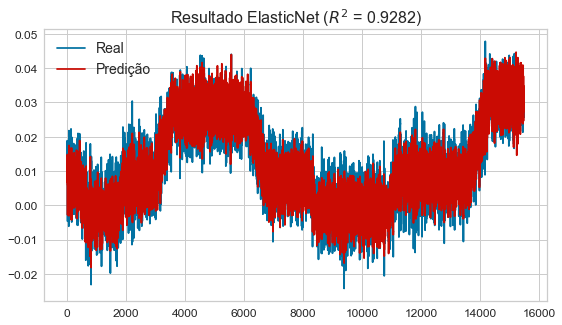

In [25]:
plt.figure(figsize=(9,5))
plt.plot(real,'b',label='Real')
plt.plot(predito,'r',label = 'Predição')
plt.title('Resultado ElasticNet ($R^2$ = 0.9282)',size=16)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.legend(fontsize=14)

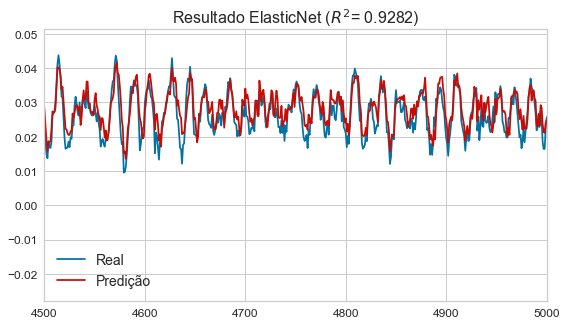

In [27]:
plt.figure(figsize=(9,5))
plt.plot(real,'b',label='Real')
plt.plot(predito,'r',label = 'Predição')
plt.title('Resultado ElasticNet ($R^2$= 0.9282)',size=16)
plt.xlim([4500,5000])
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.legend(fontsize=14)

In [28]:
predito = predito.reshape(predito.shape[0],1)
residuals = real - predito

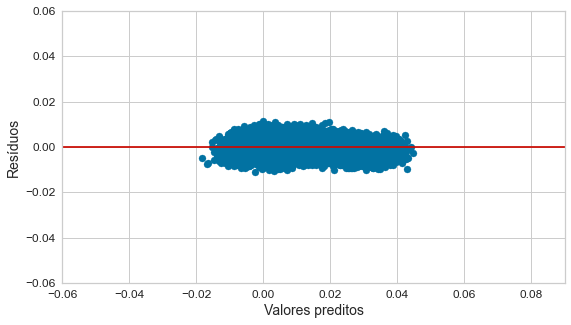

In [29]:
plt.figure(figsize=(9,5))
plt.scatter(predito,residuals)
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.xlabel('Valores preditos',size=14)
plt.ylabel('Resíduos',size=14)
plt.ylim([-0.06,0.06])
plt.xlim([-0.06,0.09])
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)

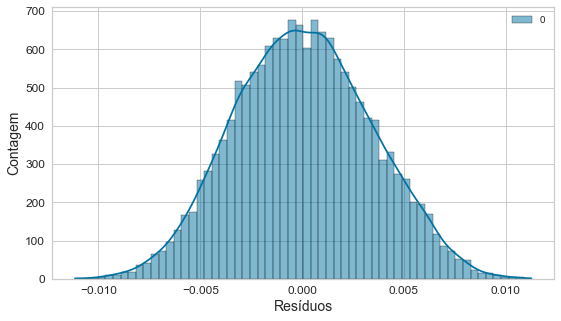

In [30]:
plt.figure(figsize=(9,5))
sns.histplot(data=residuals, kde=True,label=None)
plt.ylabel('Contagem',size=14)
plt.xlabel('Resíduos',size=14)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)

## Suport Vector Machine (SVM)

In [ ]:
from sklearn.svm import SVR

def objective(trial):
    
        
    sv_gamma = trial.suggest_float("gamma", low=0.0001, high=1, step=0.001)
    sv_C= trial.suggest_float("C", low=0.001, high=100,step=0.05)
    sv_epsilon= trial.suggest_float("epsilon", low=0.001, high=1,step=0.01)
    
    #sv_kernel = trial.suggest_categorical("kernel", ['linear', 'poly', 'rbf', 'sigmoid'])
    
    model = SVR(gamma=sv_gamma,C=sv_C,epsilon=sv_epsilon)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
#study_svm = optuna.create_study(direction='maximize')

[I 2022-12-04 09:42:46,358] A new study created in memory with name: no-name-6d9d7fea-882b-4fb7-ad6a-fb6303b9fcab


In [ ]:
#study_svm.optimize(objective, n_trials=20,show_progress_bar=True)

#trial = study_svm.best_trial

#print('Accuracy: {}'.format(trial.value))
#print("Best hyperparameters: {}".format(trial.params))

In [ ]:
#joblib.dump(study_svm, "study_SVM.pkl")

### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

def objective(trial):
    
        
    h_n_estimators = trial.suggest_int("n_estimators", low=300, high=1000, step=25)
    h_learning_rate = trial.suggest_float("learning_rate", 0.1, 1)
    h_loss = trial.suggest_categorical("loss", ['linear', 'square', 'exponential'])
    
    model = AdaBoostRegressor(learning_rate=h_learning_rate,
                                       loss=h_loss,
                                       n_estimators=h_n_estimators,
                                       random_state=0)
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
study_ab = optuna.create_study(direction='maximize')

[I 2022-12-04 10:27:50,853] A new study created in memory with name: no-name-a8e1b2ec-bf2f-49dd-81c7-a022899a8687


In [ ]:
study_ab.optimize(objective, n_trials=25)

trial_ab = study_ab.best_trial

print('Accuracy: {}'.format(trial_ab.value))
print("Best hyperparameters: {}".format(trial_ab.params))

In [ ]:
joblib.dump(study_ab, "study_AdaBost.pkl")

['study_AdaBost.pkl']

In [ ]:
optuna.visualization.plot_optimization_history(study_ab)

In [ ]:
optuna.visualization.plot_slice(study_ab)

https://medium.com/analytics-vidhya/xgboost-colsample-by-hyperparameters-explained-6c0bac1bdc1

In [ ]:
import xgboost as xgb

def objective(trial):
    
        
    #x_max_depth = trial.suggest_int("max_depth",2,20)
    #x_learning_rate = trial.suggest_float("learning_rate",0.01,0.1)
    #x_n_estimators = trial.suggest_int("n_estimators", low=50, high=600, step=10)
    #x_colsample_bytree = trial.suggest_float("bytree",0.1,0.9)
    #x_min_child_weight =  trial.suggest_int("min_child_weight",4,12)
    param = {
        'lambda': trial.suggest_loguniform('lambda',low=1e-3,high=5),
        'alpha': trial.suggest_loguniform('alpha', low=1e-3,high=5),
        'colsample_bytree': trial.suggest_float('colsample_bytree',low=0.3,high=1,step=0.1),
        'subsample': trial.suggest_float('subsample',0.1,1,step=0.1),
        'n_estimators': trial.suggest_int('n_estimators', 500, 10000, 25),
        'max_depth': trial.suggest_int('max_depth',2,20,2),
        'random_state': 2020,
        'min_split_loss': trial.suggest_loguniform('min_split_loss',low=1e-3,high=0.1),
        'min_child_weight': trial.suggest_float('min_child_weight',0.1,10,step=0.5),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel',0.3,1,step=0.1),
        'colsample_bynode': trial.suggest_float('colsample_bynode',0.3,1,step=0.1)
    }
    
    model = xgb.XGBRegressor(**param)  
    
    

   
    #model.fit(X_train_scaled,y_train)
    #p=model.predict(X_test_scaled)
    #score= r2_score(y_test,p)
    
    model.fit(X_train_scaled,y_train)
    p=model.predict(X_test_scaled)
    score= r2_score(y_test,p)
    return score

    
#study_xgbr= optuna.create_study(direction='maximize')

[I 2022-12-04 11:27:59,105] A new study created in memory with name: no-name-85c9f86f-a017-43e0-905a-4707b8fa343f


In [ ]:
study_xgbr.optimize(objective, n_trials=20)

trial_xgbr= study_xgbr.best_trial

print('Accuracy: {}'.format(trial_xgbr.value))
print("Best hyperparameters: {}".format(trial_xgbr.params))

In [ ]:
joblib.dump(study_xgbr, "study_XGBoost.pkl")

['study_XGBoost.pkl']

In [ ]:
optuna.visualization.plot_optimization_history(study_xgbr)

In [ ]:
optuna.visualization.plot_slice(study_xgbr)

In [ ]:
kajkdjhakakjhkjlkhdl

In [ ]:
study = joblib.load("study_XGBoost.pkl")
print("Best trial until now:")
print(" Value: ", study.best_trial.value)
print(" Params: ",study.best_params)

Best trial until now:
 Value:  0.7740430126296058
 Params:  {'lambda': 0.001530808845481313, 'alpha': 0.02111400159780091, 'colsample_bytree': 0.6000000000000001, 'subsample': 0.7000000000000001, 'n_estimators': 5850, 'max_depth': 10, 'min_split_loss': 0.0027632330369892592, 'min_child_weight': 7.1, 'colsample_bylevel': 0.9000000000000001, 'colsample_bynode': 1.0}


In [ ]:
import xgboost as xgb
mdl = xgb.XGBRegressor(**study.best_params,random_state=2020)
mdl.fit(X_train_scaled,y_train)
p=mdl.predict(X_test_scaled)
score= mean_squared_error(y_test,p)
score_r2 = r2_score(y_test,p)
print("RMSE: ", score)
print("R2: ", score_r2)

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\xgboost\data.py:250: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



RMSE:  0.00010128150309338829
R2:  0.7740430126296058


In [ ]:
predito_XGB = np.array(p,dtype=float)
real= np.array(y_test,dtype=float)


In [ ]:
residuals = real - predito

In [ ]:
sns.histplot(data=residuals,label='Resíduos')
plt.legend(fontsize=14)

In [ ]:
sns.boxplot(residuals)

Text(0.5, 1.0, 'Resultado XGBoost $R^2$ = 0.7740')

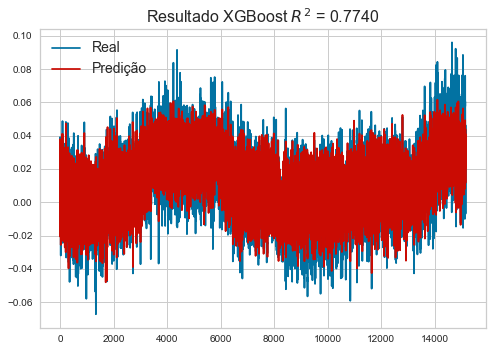

In [ ]:
plt.plot(real,'b',label='Real')
plt.plot(predito_XGB,'r',label = 'Predição')
plt.legend(fontsize=14)
plt.title('Resultado XGBoost $R^2$ = 0.7740',size=16)
#plt.xlim([9000,10000])
#plt.ylim([-0.05,0.1])
#RMSE:  0.0001065447461351567
#R2:  0.7738208762340173

In [ ]:
predicted_XGB = pd.DataFrame(p, columns = ['L/V_FR'])
predicted_XGB.to_csv(r'C:\Users\DELL\Desktop\PG\predito_xgboost.csv', index = False)
y_test.to_csv(r'C:\Users\DELL\Desktop\PG\teste_real.csv', index=False)

# Learning Curve

In [ ]:
plt.figure(figsize=(12,6))

from yellowbrick.model_selection import LearningCurve

# Load a regression dataset

# Instantiate the regression model and visualizer
#model = ElasticNet(**study_en.best_params,random_state=2020)
#visualizer = LearningCurve(model, scoring='r2')

#visualizer.fit(X_train_scaled, y_train)        # Fit the data to the visualizer
#visualizer.show()           # Finalize and render the figure

<Figure size 864x432 with 0 Axes>

# Real intrumantation IRV

In [31]:
X_IRV, y_IRV2 = df[['CC_FR', 'CC_FL', 'CC_BR', 'CC_BL','AT_Y',
'AU_FR','AU_FL','AU_BR','AU_BL','AT_X','AT_Z']], df[['L/V_FR']]
X_train_IRV,X_test_IRV,y_train_IRV,y_test_IRV = create_scaled_dataset(X_IRV,y_IRV2)

In [32]:

def objective(trial):
    
        
    h_alpha = trial.suggest_float("alpha", low=0.0001, high=1, step=0.0001)
    h_l1_ratio= trial.suggest_float("l1_ratio", low=0.0, high=1,step=0.01)
    
    h_selection = trial.suggest_categorical("selection", ['cyclic','random'])
    
    model = ElasticNet(alpha=h_alpha,l1_ratio=h_l1_ratio,
                                       
                                       selection=h_selection,
                                       random_state=0)
    model.fit(X_train_IRV,y_train_IRV)
    p=model.predict(X_test_IRV)
    score= r2_score(y_test_IRV,p)
    return score

    
study_IRV = optuna.create_study(direction='maximize')

[I 2022-12-09 14:23:27,622] A new study created in memory with name: no-name-439e7427-3041-4cc4-bcf3-ac3b127e1539


In [33]:
study_IRV.optimize(objective, n_trials=500,show_progress_bar=True)

trial_IRV = study_IRV.best_trial

print('Accuracy: {}'.format(trial_IRV.value))
print("Best hyperparameters: {}".format(trial_IRV.params))

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2022-12-09 14:23:31,166] Trial 0 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.4939, 'l1_ratio': 0.22, 'selection': 'random'}. Best is trial 0 with value: -0.07451182808005496.
[I 2022-12-09 14:23:31,201] Trial 1 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.1115, 'l1_ratio': 0.3, 'selection': 'cyclic'}. Best is trial 0 with value: -0.07451182808005496.
[I 2022-12-09 14:23:31,225] Trial 2 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.9590000000000001, 'l1_ratio': 0.8300000000000001, 'selection': 'cyclic'}. Best is trial 0 with value: -0.07451182808005496.
[I 2022-12-09 14:23:31,249] Trial 3 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.4324, 'l1_ratio': 0.4, 'selection': 'random'}. Best is trial 0 with value: -0.07451182808005496.
[I 2022-12-09 14:23:31,275] Trial 4 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.5127, 'l1_ratio': 0.42, 'selection': 'random'}. Best i

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.791e-01, tolerance: 4.164e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:23:32,301] Trial 10 finished with value: 0.80388396792143 and parameters: {'alpha': 0.6732, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 10 with value: 0.80388396792143.
[I 2022-12-09 14:23:32,342] Trial 11 finished with value: 0.021682596556425904 and parameters: {'alpha': 0.6863, 'l1_ratio': 0.01, 'selection': 'random'}. Best is trial 10 with value: 0.80388396792143.
[I 2022-12-09 14:23:32,386] Trial 12 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.7662, 'l1_ratio': 0.04, 'selection': 'random'}. Best is trial 10 with value: 0.80388396792143.
[I 2022-12-09 14:23:32,427] Trial 13 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.7117, 'l1_ratio': 0.03, 'selection': 'random'}. Best is trial 10 with value: 0.80388396792143.
[I 2022-12-09 14:23:32,469] Trial 14 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.6901, 'l1_ratio': 0.6, 'selection': 'random'}. Best is trial 10 with value: 0.803883967921

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.659e-01, tolerance: 4.164e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:23:33,923] Trial 21 finished with value: 0.8064571721315038 and parameters: {'alpha': 0.6422, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 21 with value: 0.8064571721315038.
[I 2022-12-09 14:23:33,975] Trial 22 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.646, 'l1_ratio': 0.09, 'selection': 'random'}. Best is trial 21 with value: 0.8064571721315038.
[I 2022-12-09 14:23:34,036] Trial 23 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.7936, 'l1_ratio': 0.11, 'selection': 'random'}. Best is trial 21 with value: 0.8064571721315038.
[I 2022-12-09 14:23:34,129] Trial 24 finished with value: 0.8519539542324495 and parameters: {'alpha': 0.0101, 'l1_ratio': 0.02, 'selection': 'random'}. Best is trial 24 with value: 0.8519539542324495.
[I 2022-12-09 14:23:34,241] Trial 25 finished with value: 0.2782050616339179 and parameters: {'alpha': 0.0631, 'l1_ratio': 0.09, 'selection': 'random'}. Best is trial 24 with value: 0.851953

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.007e-01, tolerance: 4.164e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:23:38,548] Trial 100 finished with value: 0.7994661243724673 and parameters: {'alpha': 0.7258, 'l1_ratio': 0.0, 'selection': 'random'}. Best is trial 29 with value: 0.8524007830549645.
[I 2022-12-09 14:23:38,595] Trial 101 finished with value: 0.8377556761996231 and parameters: {'alpha': 0.0045000000000000005, 'l1_ratio': 0.19, 'selection': 'cyclic'}. Best is trial 29 with value: 0.8524007830549645.
[I 2022-12-09 14:23:38,636] Trial 102 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.424, 'l1_ratio': 0.23, 'selection': 'cyclic'}. Best is trial 29 with value: 0.8524007830549645.
[I 2022-12-09 14:23:38,707] Trial 103 finished with value: 0.8502485885684368 and parameters: {'alpha': 0.0009000000000000001, 'l1_ratio': 0.05, 'selection': 'cyclic'}. Best is trial 29 with value: 0.8524007830549645.
[I 2022-12-09 14:23:38,758] Trial 104 finished with value: 0.8208283088295917 and parameters: {'alpha': 0.022600000000000002, 'l1_ratio': 0.05, 'selection': '

c:\Users\DELL\.conda\envs\sparsesensing\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.411e-01, tolerance: 4.164e-04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


[I 2022-12-09 14:23:50,790] Trial 317 finished with value: 0.8456440504270826 and parameters: {'alpha': 0.016900000000000002, 'l1_ratio': 0.0, 'selection': 'cyclic'}. Best is trial 139 with value: 0.8525432563946186.
[I 2022-12-09 14:23:50,834] Trial 318 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.033600000000000005, 'l1_ratio': 0.54, 'selection': 'cyclic'}. Best is trial 139 with value: 0.8525432563946186.
[I 2022-12-09 14:23:50,900] Trial 319 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.0181, 'l1_ratio': 0.59, 'selection': 'random'}. Best is trial 139 with value: 0.8525432563946186.
[I 2022-12-09 14:23:50,957] Trial 320 finished with value: 0.8524394253428356 and parameters: {'alpha': 0.0014000000000000002, 'l1_ratio': 0.2, 'selection': 'cyclic'}. Best is trial 139 with value: 0.8525432563946186.
[I 2022-12-09 14:23:51,007] Trial 321 finished with value: -0.07451182808005496 and parameters: {'alpha': 0.05960000000000001, 'l1_ratio': 

In [34]:
study_IRV.best_trial

FrozenTrial(number=432, values=[0.8525486906932502], datetime_start=datetime.datetime(2022, 12, 9, 14, 23, 57, 851416), datetime_complete=datetime.datetime(2022, 12, 9, 14, 23, 57, 907267), params={'alpha': 0.00030000000000000003, 'l1_ratio': 0.8300000000000001, 'selection': 'cyclic'}, distributions={'alpha': FloatDistribution(high=1.0, log=False, low=0.0001, step=0.0001), 'l1_ratio': FloatDistribution(high=1.0, log=False, low=0.0, step=0.01), 'selection': CategoricalDistribution(choices=('cyclic', 'random'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=432, state=TrialState.COMPLETE, value=None)

In [35]:
mdl_IRV = ElasticNet(**study_IRV.best_params,random_state=2020)
mdl_IRV.fit(X_train_IRV,y_train_IRV)
p=mdl_IRV.predict(X_test_IRV)
score_IRV = mean_squared_error(y_test_IRV,p)
score_r2_IRV = r2_score(y_test_IRV,p)
print("RMSE: ", score_IRV)
print("R2: ", score_r2_IRV)
predito_IRV = np.array(p,dtype=float)
real_IRV= np.array(y_test_IRV,dtype=float)

RMSE:  2.8466230770182157e-05
R2:  0.8525486906932502


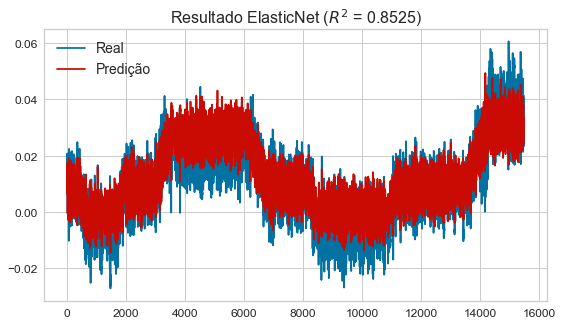

In [36]:
plt.figure(figsize=(9,5))
plt.plot(real_IRV,'b',label='Real')
plt.plot(predito_IRV,'r',label = 'Predição')
plt.title('Resultado ElasticNet ($R^2$ = 0.8525)',size=16)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.legend(fontsize=14)

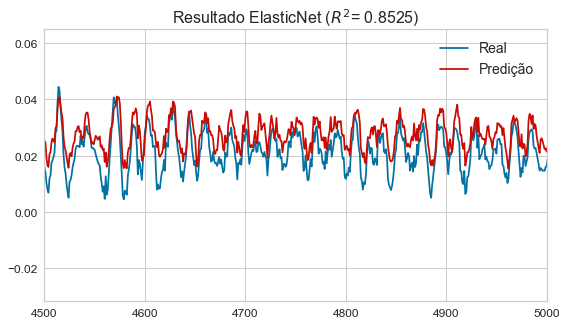

In [37]:
plt.figure(figsize=(9,5))
plt.plot(real_IRV,'b',label='Real')
plt.plot(predito_IRV,'r',label = 'Predição')
plt.title('Resultado ElasticNet ($R^2$= 0.8525)',size=16)
plt.xlim([4500,5000])
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)
plt.legend(fontsize=14)

In [39]:
predito_IRV = predito_IRV.reshape(predito_IRV.shape[0],1)
residuals_IRV = real_IRV - predito_IRV

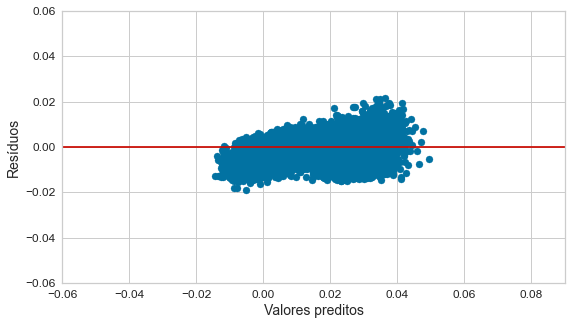

In [40]:
plt.figure(figsize=(9,5))
plt.scatter(predito_IRV,residuals_IRV)
plt.axhline(y = 0, color = 'r', linestyle = '-')
plt.xlabel('Valores preditos',size=14)
plt.ylabel('Resíduos',size=14)
plt.ylim([-0.06,0.06])
plt.xlim([-0.06,0.09])
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)

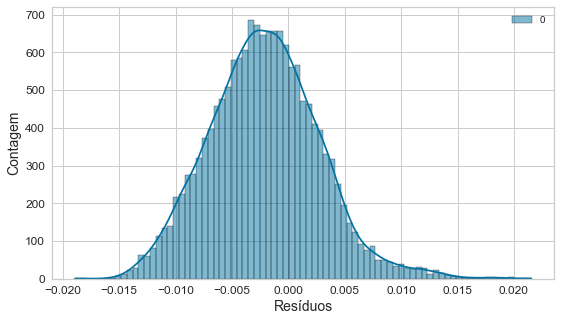

In [41]:
plt.figure(figsize=(9,5))
sns.histplot(data=residuals_IRV, kde=True,label=None)
plt.ylabel('Contagem',size=14)
plt.xlabel('Resíduos',size=14)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)